# Train using balanced subsets of data - 224x224 Redux

### Findings
- Dataset has propensity for flucting validation loss, even with increated dropotuand reduced model layers
- Training at very low LR (1e4) gives more stable results, bult ultimately sub-optimal final results
- Better results achieved using higher LR, and using SaveModelCallback to capture local minima
- Combining multiple top learners gives significantly better results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import collections

In [3]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate
import os
import pickle

import scipy
from scipy.stats import gmean, hmean

In [4]:
import fastai_addons   #add plot2 extension -- learn.recorder.plot2()
from fastai_addons import interpretation_summary, plot_confusion_matrix, \
                          get_accuracy, analyze_confidence, accuracy_vs_threshold, \
                          show_incremental_accuracy,  analyze_low_confidence, \
                          plot_confusion_matrix_thresh, get_val_stats, model_cutter

In [5]:
#from pneumonia_loaders import *

In [6]:
from pneumonia_loaders import show_categories
from pneumonia_new_loader import get_db

In [7]:
from helpers import get_best_stats, show_results, show_results
from helpers import StatsRepo, stats_repo_unit_test
from helpers import _get_learner, _get_interp, analyze_interp, _do_train

# Config

In [8]:
model = models.resnet18
size=224
n_samples=100    # total number of training samples

In [9]:
#data_base = Path()/'data'
data_base = Path.home()/'big_ssd'/'Data'/'ChestXRay_Kaggle'




#model_base = Path('D:/Users/Doug/Models/chest_xray')
model_base = Path.home()/'D_Drive'/'Models'/'chest_xray'

all_bs = {224:31, 448:31, 896:7}

In [10]:
prefix = f'g18_{size}'
short_prefix = f'g18_{size}'

data_subdir  = f'chest_xray_{size}'
model_subdir = f'g18_{size}'

if size in [224]:
    path = data_base/data_subdir
    model_dir = (model_base/model_subdir).absolute()
    bs = all_bs[size]
else:
    raise Exception('Unknown size')

In [11]:
bs, model_dir

(31, PosixPath('/home/doug/D_Drive/Models/chest_xray/g18_224'))

In [12]:
path.ls()

[PosixPath('/home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224/models'),
 PosixPath('/home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224/val'),
 PosixPath('/home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224/train'),
 PosixPath('/home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224/test')]

# Code

In [13]:
def my_transforms():
    tfms = get_transforms(do_flip=True, flip_vert=False,
                          max_zoom=1.3, max_lighting=0.3)
    return tfms

In [14]:
def get_params(all_lr=[1e-2, 3e-3, 1e-3], all_cycles=[1,2,4, 8]):
    global short_prefix
    for lr in all_lr:
        for cycles in all_cycles:
            key = f'{short_prefix}_lr_{lr}_cyc_{cycles}'
            yield key, {'cycles':cycles, 'max_lr':lr}

In [15]:
def restore_learner(name, ps=0.5, compute_baseline=True):
    learn = get_learner(ps=ps)
    learn.load(name)
    
    if compute_baseline:
        base = learn.svalidate()
        base = {'loss': base[0], 'error_rate': float(base[1]), 'accuracy': float(base[2])}
    else:
        base = None
    return learn, base

def refine_learner(name, ps=0.8, lr=1e-6, cycles=16, **kwargs):
    learn, base = restore_learner(name, ps=ps)
    print('base:', base)
    learn.unfreeze()
    learn.fit_one_cycle(cycles, max_lr=slice(lr,lr),
                        callbacks=[SaveModelCallback(learn, every='improvement', 
                                   monitor='accuracy', name='best')], **kwargs)
    stats = get_best_stats(learn)
    
    if stats['error_rate'] < base['error_rate']:
        new_name = f'{name}_r_lr{lr}_c{cycles}_ps{ps}'
        print('keeping:', stats)
        return learn, stats, new_name
    else:
        print('ignoring:', stats)
        return None, None, None

# Additional Configuration

###### Initialize stats repo (use prior contents if available)

In [16]:
all_stats = StatsRepo(prefix, force_init=False, verbose=True)

initialializing stats


###### Get Training/Validation/Test dataset for  Normal / Viral / Bacterial

In [17]:
#data = get_db_np(path, size=size, scale=10, tfms=my_transforms())
data, data_test = get_db(path, kind='np', n_samples=n_samples, scale=1, include_test=True,
                  size=size, bs=bs, tfms=my_transforms())
print('Training set:')
show_categories(data.train_ds.y)
print('\nValidation set:')
show_categories(data.valid_ds.y)
print('\nTest set:')
show_categories(data_test.valid_ds.y)

Training set:
  NORMAL    :   100     50.0%
  PNEUMONIA :   100     50.0%
  Total     :   200

Validation set:
  NORMAL    :   100     50.0%
  PNEUMONIA :   100     50.0%
  Total     :   200

Test set:
  NORMAL    :   100     50.0%
  PNEUMONIA :   100     50.0%
  Total     :   200


In [18]:
data

ImageDataBunch;

Train: LabelList (200 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
NORMAL,PNEUMONIA,NORMAL,NORMAL,PNEUMONIA
Path: /home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224;

Valid: LabelList (200 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
PNEUMONIA,NORMAL,PNEUMONIA,PNEUMONIA,NORMAL
Path: /home/doug/big_ssd/Data/ChestXRay_Kaggle/chest_xray_224;

Test: None

###### Define configuration specific functions and initialize stats repo (use prior contents if available)

In [19]:
get_learner = partial(_get_learner, db=data, model=model, model_dir=model_dir)
get_learner_test = partial(_get_learner, db=data_test, model=model, model_dir=model_dir)

get_interp = partial(_get_interp, get_learner=get_learner)
get_interp_test = partial(_get_interp, get_learner=get_learner_test)

do_train = partial(_do_train, get_learner=get_learner, stats_repo=all_stats)
do_train_ls = partial(_do_train, get_learner=get_learner, stats_repo=all_stats,
                      use_label_smoothing=True)

In [20]:
import scipy
from scipy.stats import gmean, hmean

def compute_acc(preds, y_true):
    yy = np.argmax(preds, axis=-1)
    return np.mean(yy==y_true)
    

def combine_predictions(all_interp):
    y_true = to_np(all_interp[0][1].y_true)
    all_preds = np.stack([to_np(interp.preds) for _, interp in all_interp])
    
    preds = np.mean(all_preds, axis=0)
    acc_m = compute_acc(preds, y_true) 
    
    preds = np.median(all_preds, axis=0)
    acc_med = compute_acc(preds, y_true)
    
    preds = gmean(all_preds, axis=0)
    acc_g = compute_acc(preds, y_true)
    
    preds = hmean(all_preds, axis=0)
    acc_h = compute_acc(preds, y_true)
    
    print(f'accuracy -- mean: {acc_m:0.3f}   median: {acc_med:0.3f}   gmean: {acc_g:0.3f}   hmean: {acc_h:0.3f}')
    return acc_m, acc_med, acc_g, acc_h

## Various Development Tests
Disabled by default

# Analysis

In [21]:
# barrier after initialization for notebook restart
#assert False

### Basic LR Finder runs

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07 
Min loss divided by 10: 4.79E-03
Min numerical gradient: 2.51E-03  (smoothed)
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-03


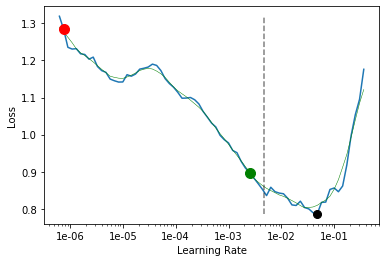

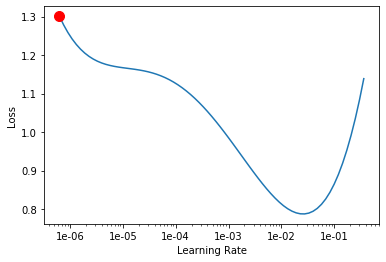

In [22]:
learn = get_learner()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

## Explore Baseline

g18_224_lr_0.01_cyc_1


Better model found at epoch 0 with accuracy value: 0.7850000262260437.


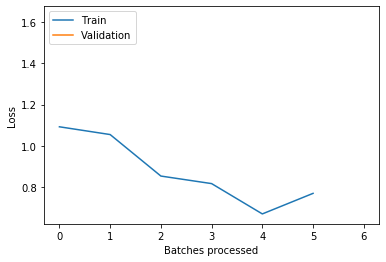

g18_224_lr_0.01_cyc_2


Better model found at epoch 0 with accuracy value: 0.8050000071525574.


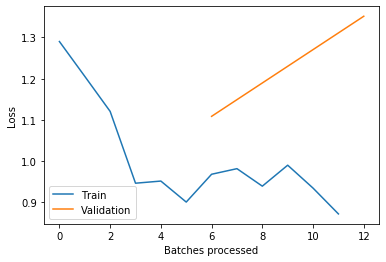

g18_224_lr_0.01_cyc_4


Better model found at epoch 0 with accuracy value: 0.699999988079071.
Better model found at epoch 1 with accuracy value: 0.8149999976158142.


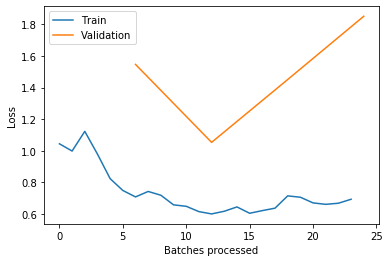

g18_224_lr_0.01_cyc_8


Better model found at epoch 0 with accuracy value: 0.699999988079071.
Better model found at epoch 2 with accuracy value: 0.7950000166893005.
Better model found at epoch 4 with accuracy value: 0.8450000286102295.


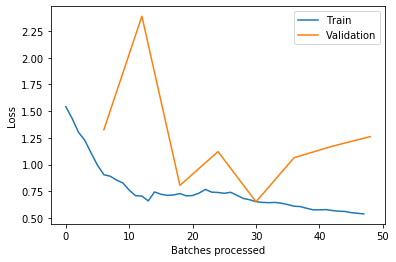

g18_224_lr_0.003_cyc_1


Better model found at epoch 0 with accuracy value: 0.8050000071525574.


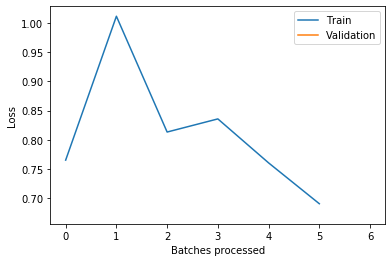

g18_224_lr_0.003_cyc_2


Better model found at epoch 0 with accuracy value: 0.7250000238418579.
Better model found at epoch 1 with accuracy value: 0.8050000071525574.


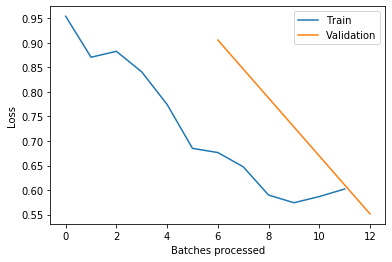

g18_224_lr_0.003_cyc_4


Better model found at epoch 0 with accuracy value: 0.7699999809265137.


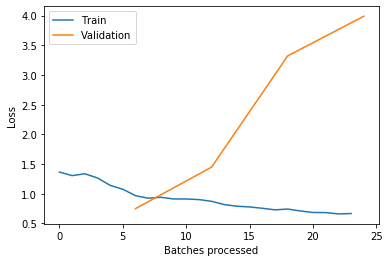

g18_224_lr_0.003_cyc_8


Better model found at epoch 0 with accuracy value: 0.699999988079071.
Better model found at epoch 1 with accuracy value: 0.8450000286102295.


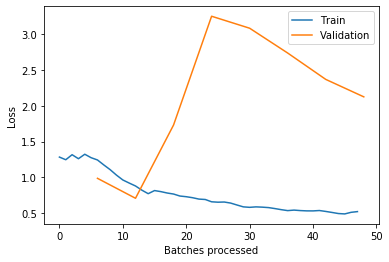

g18_224_lr_0.001_cyc_1


Better model found at epoch 0 with accuracy value: 0.800000011920929.


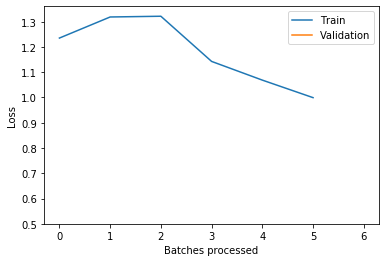

g18_224_lr_0.001_cyc_2


Better model found at epoch 0 with accuracy value: 0.6949999928474426.
Better model found at epoch 1 with accuracy value: 0.7799999713897705.


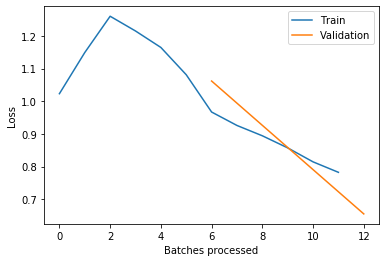

g18_224_lr_0.001_cyc_4


Better model found at epoch 0 with accuracy value: 0.6349999904632568.
Better model found at epoch 1 with accuracy value: 0.6600000262260437.


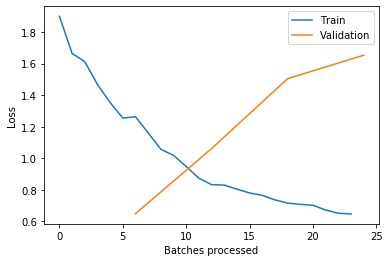

g18_224_lr_0.001_cyc_8


Better model found at epoch 0 with accuracy value: 0.6299999952316284.
Better model found at epoch 1 with accuracy value: 0.7749999761581421.


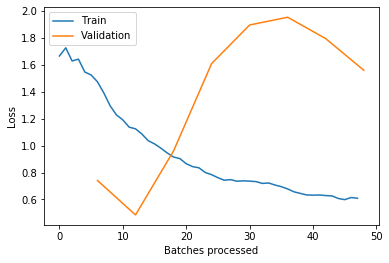

saved stats to: stats/g18_224_stats.p


In [23]:
for key, params in get_params():
    do_train(key, **params)
all_stats.save()

g18_224_lr_0.0003_cyc_1


Better model found at epoch 0 with accuracy value: 0.45500001311302185.


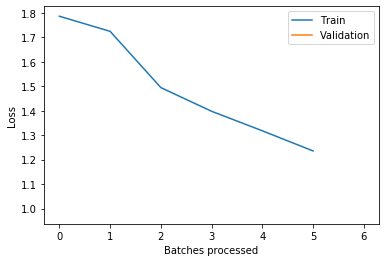

g18_224_lr_0.0003_cyc_2


Better model found at epoch 0 with accuracy value: 0.7350000143051147.
Better model found at epoch 1 with accuracy value: 0.824999988079071.


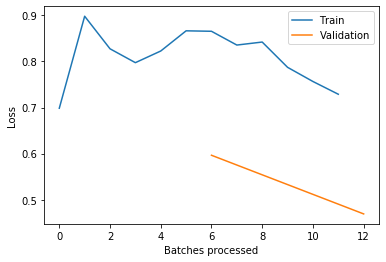

g18_224_lr_0.0003_cyc_4


Better model found at epoch 0 with accuracy value: 0.5849999785423279.
Better model found at epoch 1 with accuracy value: 0.6150000095367432.


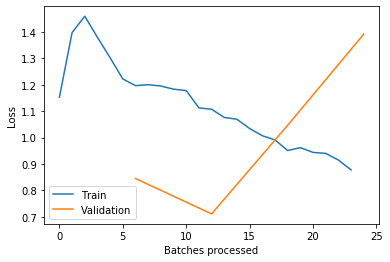

g18_224_lr_0.0003_cyc_8


Better model found at epoch 0 with accuracy value: 0.5899999737739563.
Better model found at epoch 1 with accuracy value: 0.7350000143051147.
Better model found at epoch 2 with accuracy value: 0.7400000095367432.


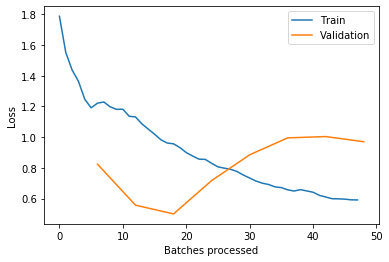

g18_224_lr_0.0001_cyc_1


Better model found at epoch 0 with accuracy value: 0.47999998927116394.


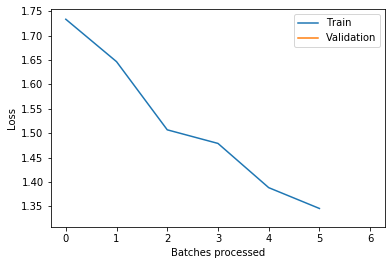

g18_224_lr_0.0001_cyc_2


Better model found at epoch 0 with accuracy value: 0.6650000214576721.
Better model found at epoch 1 with accuracy value: 0.6800000071525574.


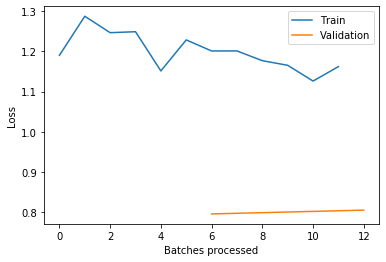

g18_224_lr_0.0001_cyc_4


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.5699999928474426.
Better model found at epoch 2 with accuracy value: 0.6299999356269836.
Better model found at epoch 3 with accuracy value: 0.6549999713897705.


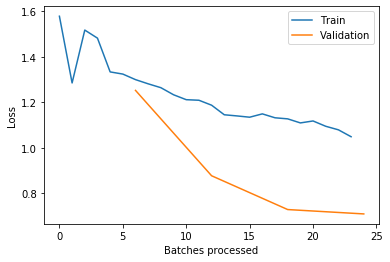

g18_224_lr_0.0001_cyc_8


Better model found at epoch 0 with accuracy value: 0.32499998807907104.
Better model found at epoch 1 with accuracy value: 0.4350000023841858.
Better model found at epoch 2 with accuracy value: 0.4749999940395355.
Better model found at epoch 3 with accuracy value: 0.5049999952316284.
Better model found at epoch 4 with accuracy value: 0.5199999809265137.
Better model found at epoch 5 with accuracy value: 0.5249999761581421.
Better model found at epoch 6 with accuracy value: 0.5649999976158142.
Better model found at epoch 7 with accuracy value: 0.5799999833106995.


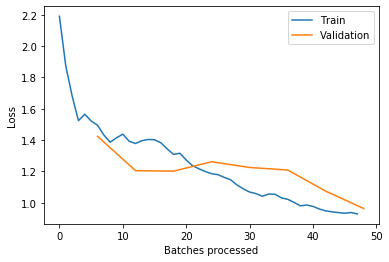

saved stats to: stats/g18_224_stats.p


In [24]:
for key, params in get_params(all_lr=[3e-4, 1e-4]):
    do_train(key, **params)
all_stats.save()

In [25]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.155  med: 0.222   Loss -- best: 0.469  med: 0.710

g18_224_lr_0.01_cyc_8  error_rate: 0.155   accuracy: 0.845   loss:0.6509
g18_224_lr_0.003_cyc_8  error_rate: 0.155   accuracy: 0.845   loss:0.7080
g18_224_lr_0.0003_cyc_2  error_rate: 0.175   accuracy: 0.825   loss:0.4692
g18_224_lr_0.01_cyc_4  error_rate: 0.185   accuracy: 0.815   loss:1.0534
g18_224_lr_0.01_cyc_2  error_rate: 0.195   accuracy: 0.805   loss:1.1088
g18_224_lr_0.003_cyc_1  error_rate: 0.195   accuracy: 0.805   loss:0.6733
g18_224_lr_0.003_cyc_2  error_rate: 0.195   accuracy: 0.805   loss:0.5514
g18_224_lr_0.001_cyc_1  error_rate: 0.200   accuracy: 0.800   loss:0.5390
g18_224_lr_0.01_cyc_1  error_rate: 0.215   accuracy: 0.785   loss:1.6283
g18_224_lr_0.001_cyc_2  error_rate: 0.220   accuracy: 0.780   loss:0.6551


g18_224_lr_0.03_cyc_1


Better model found at epoch 0 with accuracy value: 0.5249999761581421.


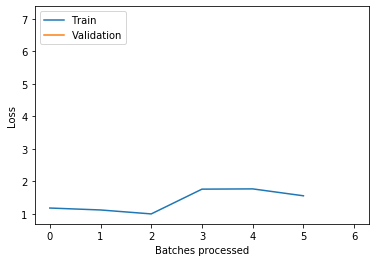

g18_224_lr_0.03_cyc_2


Better model found at epoch 0 with accuracy value: 0.7149999737739563.


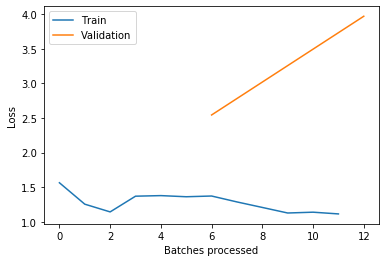

g18_224_lr_0.03_cyc_4


Better model found at epoch 0 with accuracy value: 0.6700000166893005.
Better model found at epoch 3 with accuracy value: 0.7099999785423279.


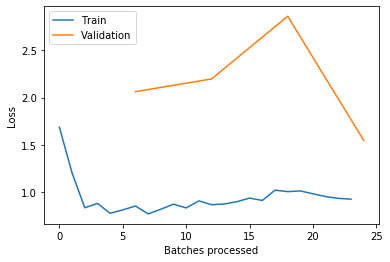

g18_224_lr_0.03_cyc_8


Better model found at epoch 0 with accuracy value: 0.8500000238418579.
Better model found at epoch 7 with accuracy value: 0.8550000190734863.


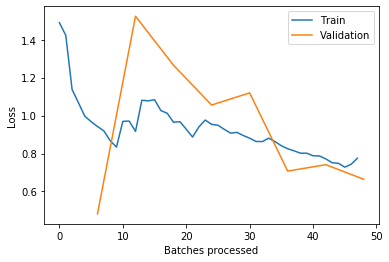

g18_224_lr_0.1_cyc_1


Better model found at epoch 0 with accuracy value: 0.39500001072883606.


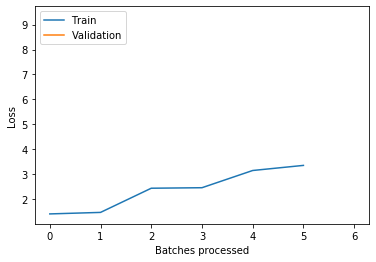

g18_224_lr_0.1_cyc_2


Better model found at epoch 0 with accuracy value: 0.5.


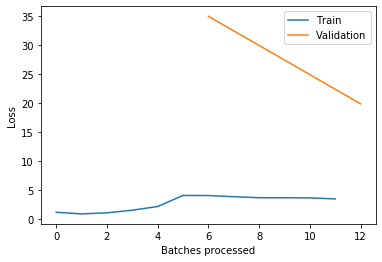

g18_224_lr_0.1_cyc_4


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 2 with accuracy value: 0.6600000262260437.


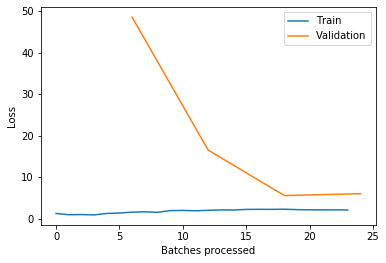

g18_224_lr_0.1_cyc_8


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.5099999904632568.
Better model found at epoch 5 with accuracy value: 0.7200000286102295.
Better model found at epoch 6 with accuracy value: 0.7950000166893005.
Better model found at epoch 7 with accuracy value: 0.8349999785423279.


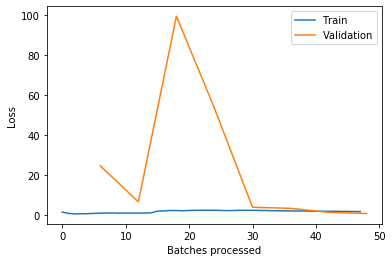

saved stats to: stats/g18_224_stats.p


In [26]:
for key, params in get_params(all_lr=[3e-2, 1e-1]):
    do_train(key, **params)
all_stats.save()

In [27]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.145  med: 0.245   Loss -- best: 0.469  med: 0.851

g18_224_lr_0.03_cyc_8  error_rate: 0.145   accuracy: 0.855   loss:0.6643
g18_224_lr_0.01_cyc_8  error_rate: 0.155   accuracy: 0.845   loss:0.6509
g18_224_lr_0.003_cyc_8  error_rate: 0.155   accuracy: 0.845   loss:0.7080
g18_224_lr_0.1_cyc_8  error_rate: 0.165   accuracy: 0.835   loss:0.8964
g18_224_lr_0.0003_cyc_2  error_rate: 0.175   accuracy: 0.825   loss:0.4692
g18_224_lr_0.01_cyc_4  error_rate: 0.185   accuracy: 0.815   loss:1.0534
g18_224_lr_0.01_cyc_2  error_rate: 0.195   accuracy: 0.805   loss:1.1088
g18_224_lr_0.003_cyc_1  error_rate: 0.195   accuracy: 0.805   loss:0.6733
g18_224_lr_0.003_cyc_2  error_rate: 0.195   accuracy: 0.805   loss:0.5514
g18_224_lr_0.001_cyc_1  error_rate: 0.200   accuracy: 0.800   loss:0.5390


g18_224_lr_0.001_cyc_16_ps_0.5


Better model found at epoch 0 with accuracy value: 0.5699999928474426.
Better model found at epoch 1 with accuracy value: 0.7200000286102295.
Better model found at epoch 2 with accuracy value: 0.7649999856948853.
Better model found at epoch 10 with accuracy value: 0.7850000262260437.
Better model found at epoch 11 with accuracy value: 0.8399999737739563.
Better model found at epoch 12 with accuracy value: 0.8550000190734863.
Better model found at epoch 14 with accuracy value: 0.8650000095367432.
Better model found at epoch 15 with accuracy value: 0.8700000047683716.


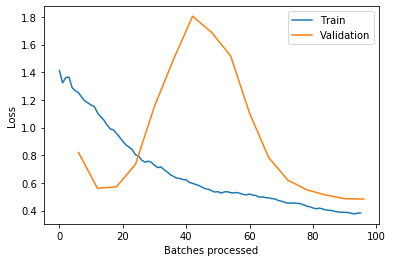

g18_224_lr_0.001_cyc_16_ps_0.8


Better model found at epoch 0 with accuracy value: 0.44999998807907104.
Better model found at epoch 1 with accuracy value: 0.5600000023841858.
Better model found at epoch 2 with accuracy value: 0.6150000095367432.
Better model found at epoch 3 with accuracy value: 0.6349999904632568.
Better model found at epoch 4 with accuracy value: 0.6399999856948853.
Better model found at epoch 7 with accuracy value: 0.675000011920929.
Better model found at epoch 8 with accuracy value: 0.7250000238418579.
Better model found at epoch 9 with accuracy value: 0.7549999952316284.
Better model found at epoch 10 with accuracy value: 0.7749999761581421.
Better model found at epoch 11 with accuracy value: 0.8149999976158142.
Better model found at epoch 12 with accuracy value: 0.8299999833106995.
Better model found at epoch 13 with accuracy value: 0.8450000286102295.
Better model found at epoch 14 with accuracy value: 0.8550000190734863.
Better model found at epoch 15 with accuracy value: 0.8650000095367432.


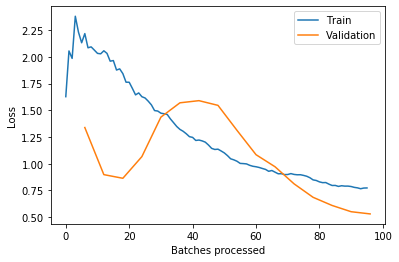

g18_224_lr_0.001_cyc_16_ps_0.85


Better model found at epoch 0 with accuracy value: 0.5899999737739563.
Better model found at epoch 1 with accuracy value: 0.6800000071525574.
Better model found at epoch 2 with accuracy value: 0.7350000143051147.
Better model found at epoch 5 with accuracy value: 0.7649999856948853.
Better model found at epoch 6 with accuracy value: 0.7850000262260437.
Better model found at epoch 8 with accuracy value: 0.7900000214576721.
Better model found at epoch 10 with accuracy value: 0.8199999928474426.
Better model found at epoch 11 with accuracy value: 0.8450000286102295.
Better model found at epoch 12 with accuracy value: 0.8650000095367432.
Better model found at epoch 13 with accuracy value: 0.875.
Better model found at epoch 15 with accuracy value: 0.8799999952316284.


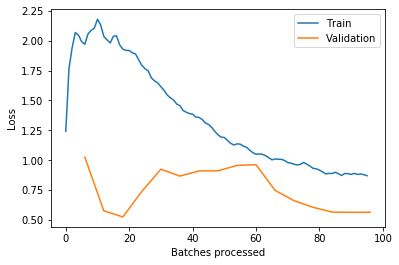

g18_224_lr_0.001_cyc_16_ps_0.9


Better model found at epoch 0 with accuracy value: 0.5199999809265137.
Better model found at epoch 2 with accuracy value: 0.5549999475479126.
Better model found at epoch 3 with accuracy value: 0.5799999833106995.
Better model found at epoch 4 with accuracy value: 0.6050000190734863.
Better model found at epoch 5 with accuracy value: 0.6150000095367432.
Better model found at epoch 8 with accuracy value: 0.6499999761581421.
Better model found at epoch 9 with accuracy value: 0.699999988079071.
Better model found at epoch 10 with accuracy value: 0.7549999952316284.
Better model found at epoch 11 with accuracy value: 0.7950000166893005.
Better model found at epoch 12 with accuracy value: 0.8349999785423279.
Better model found at epoch 13 with accuracy value: 0.8500000238418579.
Better model found at epoch 14 with accuracy value: 0.8550000190734863.


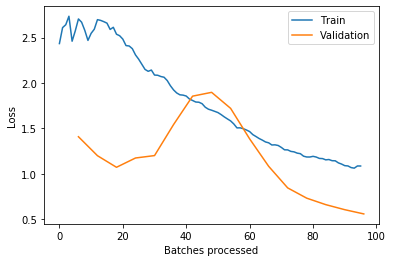

g18_224_lr_0.0003_cyc_16_ps_0.5


Better model found at epoch 0 with accuracy value: 0.49000000953674316.
Better model found at epoch 1 with accuracy value: 0.5550000071525574.
Better model found at epoch 2 with accuracy value: 0.6899999976158142.
Better model found at epoch 3 with accuracy value: 0.7850000262260437.
Better model found at epoch 4 with accuracy value: 0.7900000214576721.
Better model found at epoch 8 with accuracy value: 0.800000011920929.
Better model found at epoch 9 with accuracy value: 0.8149999976158142.
Better model found at epoch 10 with accuracy value: 0.8299999833106995.
Better model found at epoch 13 with accuracy value: 0.8349999785423279.


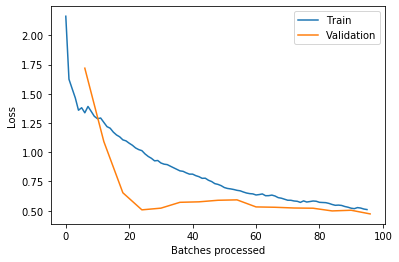

g18_224_lr_0.0003_cyc_16_ps_0.8


Better model found at epoch 0 with accuracy value: 0.5099999904632568.
Better model found at epoch 1 with accuracy value: 0.5699999928474426.
Better model found at epoch 3 with accuracy value: 0.60999995470047.
Better model found at epoch 4 with accuracy value: 0.6549999713897705.
Better model found at epoch 7 with accuracy value: 0.6949999928474426.
Better model found at epoch 8 with accuracy value: 0.7200000286102295.
Better model found at epoch 9 with accuracy value: 0.7400000095367432.
Better model found at epoch 10 with accuracy value: 0.7450000047683716.
Better model found at epoch 11 with accuracy value: 0.7699999809265137.
Better model found at epoch 12 with accuracy value: 0.8100000023841858.
Better model found at epoch 13 with accuracy value: 0.824999988079071.
Better model found at epoch 14 with accuracy value: 0.8399999737739563.
Better model found at epoch 15 with accuracy value: 0.8450000286102295.


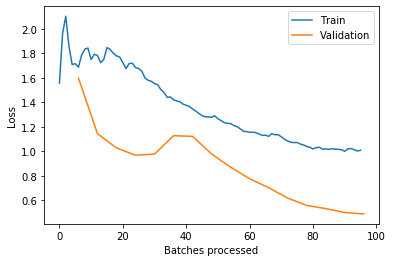

g18_224_lr_0.0003_cyc_16_ps_0.85


Better model found at epoch 0 with accuracy value: 0.48500001430511475.
Better model found at epoch 1 with accuracy value: 0.49000000953674316.
Better model found at epoch 2 with accuracy value: 0.550000011920929.
Better model found at epoch 3 with accuracy value: 0.6399999856948853.
Better model found at epoch 4 with accuracy value: 0.7300000190734863.
Better model found at epoch 5 with accuracy value: 0.7850000262260437.
Better model found at epoch 6 with accuracy value: 0.824999988079071.
Better model found at epoch 7 with accuracy value: 0.8349999785423279.
Better model found at epoch 10 with accuracy value: 0.8500000238418579.


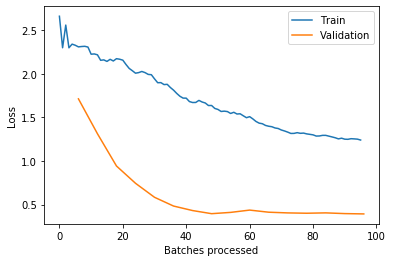

g18_224_lr_0.0003_cyc_16_ps_0.9


Better model found at epoch 0 with accuracy value: 0.3499999940395355.
Better model found at epoch 1 with accuracy value: 0.4300000071525574.
Better model found at epoch 2 with accuracy value: 0.47999998927116394.
Better model found at epoch 3 with accuracy value: 0.5099999904632568.
Better model found at epoch 5 with accuracy value: 0.5299999713897705.
Better model found at epoch 6 with accuracy value: 0.550000011920929.
Better model found at epoch 7 with accuracy value: 0.5899999737739563.
Better model found at epoch 8 with accuracy value: 0.6399999856948853.
Better model found at epoch 9 with accuracy value: 0.6949999928474426.
Better model found at epoch 10 with accuracy value: 0.7549999952316284.
Better model found at epoch 11 with accuracy value: 0.824999988079071.
Better model found at epoch 12 with accuracy value: 0.8450000286102295.
Better model found at epoch 13 with accuracy value: 0.8650000095367432.
Better model found at epoch 15 with accuracy value: 0.8849999904632568.


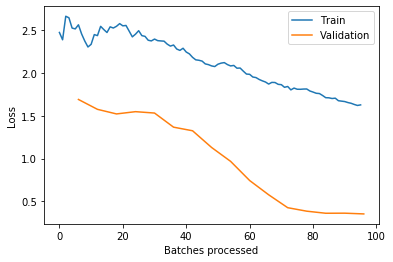

g18_224_lr_0.0001_cyc_16_ps_0.5


Better model found at epoch 0 with accuracy value: 0.5450000166893005.
Better model found at epoch 3 with accuracy value: 0.6050000190734863.
Better model found at epoch 4 with accuracy value: 0.6200000047683716.
Better model found at epoch 7 with accuracy value: 0.6449999809265137.
Better model found at epoch 9 with accuracy value: 0.6850000023841858.
Better model found at epoch 10 with accuracy value: 0.7200000286102295.
Better model found at epoch 11 with accuracy value: 0.75.
Better model found at epoch 12 with accuracy value: 0.7749999761581421.
Better model found at epoch 13 with accuracy value: 0.7850000262260437.


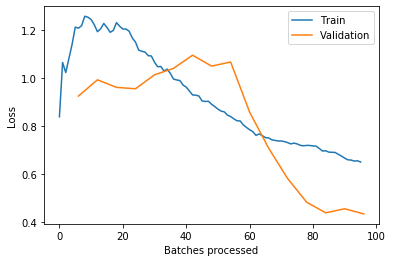

g18_224_lr_0.0001_cyc_16_ps_0.8


Better model found at epoch 0 with accuracy value: 0.5149999856948853.
Better model found at epoch 1 with accuracy value: 0.5199999809265137.
Better model found at epoch 3 with accuracy value: 0.5400000214576721.
Better model found at epoch 4 with accuracy value: 0.550000011920929.
Better model found at epoch 5 with accuracy value: 0.6700000166893005.
Better model found at epoch 6 with accuracy value: 0.6949999928474426.
Better model found at epoch 7 with accuracy value: 0.7300000190734863.
Better model found at epoch 8 with accuracy value: 0.75.
Better model found at epoch 9 with accuracy value: 0.7599999904632568.
Better model found at epoch 10 with accuracy value: 0.7799999713897705.
Better model found at epoch 11 with accuracy value: 0.7900000214576721.
Better model found at epoch 12 with accuracy value: 0.8100000023841858.
Better model found at epoch 14 with accuracy value: 0.8149999976158142.


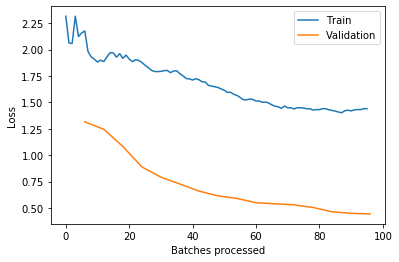

g18_224_lr_0.0001_cyc_16_ps_0.85


Better model found at epoch 0 with accuracy value: 0.5249999761581421.
Better model found at epoch 5 with accuracy value: 0.5400000214576721.
Better model found at epoch 6 with accuracy value: 0.574999988079071.
Better model found at epoch 7 with accuracy value: 0.625.
Better model found at epoch 8 with accuracy value: 0.6899999976158142.
Better model found at epoch 9 with accuracy value: 0.75.
Better model found at epoch 10 with accuracy value: 0.7699999809265137.
Better model found at epoch 11 with accuracy value: 0.7850000262260437.
Better model found at epoch 12 with accuracy value: 0.800000011920929.
Better model found at epoch 14 with accuracy value: 0.8050000071525574.


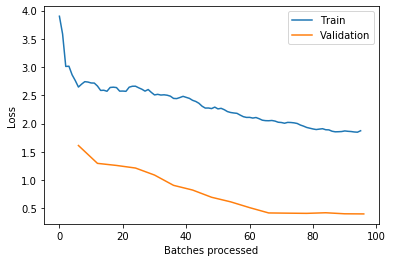

g18_224_lr_0.0001_cyc_16_ps_0.9


Better model found at epoch 0 with accuracy value: 0.5350000262260437.
Better model found at epoch 1 with accuracy value: 0.5649999976158142.
Better model found at epoch 2 with accuracy value: 0.5799999833106995.
Better model found at epoch 3 with accuracy value: 0.6050000190734863.
Better model found at epoch 4 with accuracy value: 0.6499999761581421.
Better model found at epoch 6 with accuracy value: 0.675000011920929.
Better model found at epoch 7 with accuracy value: 0.7149999737739563.
Better model found at epoch 9 with accuracy value: 0.7300000190734863.
Better model found at epoch 10 with accuracy value: 0.75.
Better model found at epoch 11 with accuracy value: 0.7649999856948853.
Better model found at epoch 12 with accuracy value: 0.7699999809265137.
Better model found at epoch 13 with accuracy value: 0.7900000214576721.
Better model found at epoch 14 with accuracy value: 0.7950000166893005.


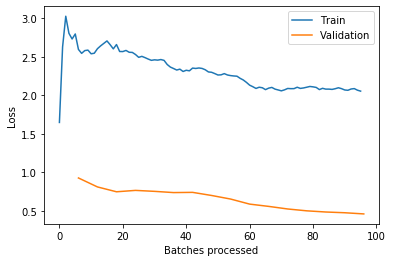

saved stats to: stats/g18_224_stats.p


In [28]:
for key, params in get_params(all_cycles=[16], all_lr=[1e-3, 3e-4, 1e-4]):
    for ps in [0.5, 0.8, 0.85, 0.9]:
        do_train(key, ps=ps, **params)
all_stats.save()

In [29]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.115  med: 0.203   Loss -- best: 0.353  med: 0.669

g18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.115   accuracy: 0.885   loss:0.3532
g18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.120   accuracy: 0.880   loss:0.5644
g18_224_lr_0.001_cyc_16_ps_0.5  error_rate: 0.130   accuracy: 0.870   loss:0.4836
g18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.135   accuracy: 0.865   loss:0.5309
g18_224_lr_0.001_cyc_16_ps_0.9  error_rate: 0.145   accuracy: 0.855   loss:0.5597
g18_224_lr_0.03_cyc_8  error_rate: 0.145   accuracy: 0.855   loss:0.6643
g18_224_lr_0.0003_cyc_16_ps_0.85  error_rate: 0.150   accuracy: 0.850   loss:0.4128
g18_224_lr_0.0003_cyc_16_ps_0.8  error_rate: 0.155   accuracy: 0.845   loss:0.4885
g18_224_lr_0.01_cyc_8  error_rate: 0.155   accuracy: 0.845   loss:0.6509
g18_224_lr_0.003_cyc_8  error_rate: 0.155   accuracy: 0.845   loss:0.7080


### Focus on specific configurations

18_224cut_lr_0.01_cyc_8

g18_224_lr_0.01_cyc_8_i0


Better model found at epoch 0 with accuracy value: 0.8349999785423279.


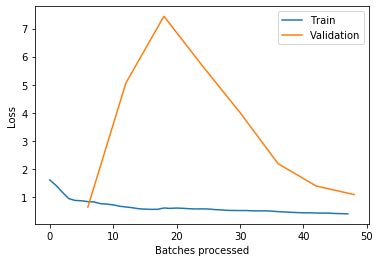

g18_224_lr_0.01_cyc_8_i1


Better model found at epoch 0 with accuracy value: 0.824999988079071.


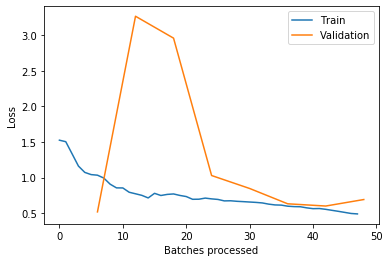

g18_224_lr_0.01_cyc_8_i2


Better model found at epoch 0 with accuracy value: 0.8399999737739563.
Better model found at epoch 1 with accuracy value: 0.8849999904632568.


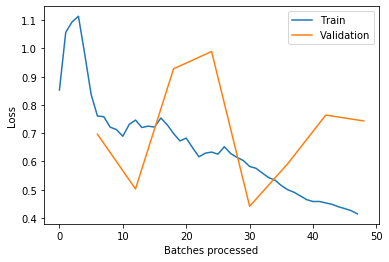

g18_224_lr_0.01_cyc_8_i3


Better model found at epoch 0 with accuracy value: 0.8450000286102295.


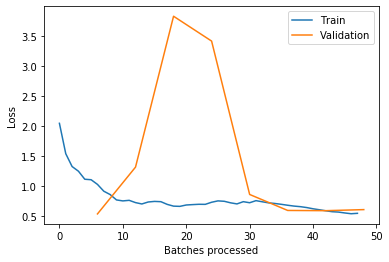

g18_224_lr_0.01_cyc_8_i4


Better model found at epoch 0 with accuracy value: 0.8199999928474426.


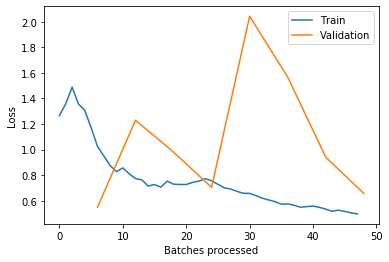

g18_224_lr_0.01_cyc_8_i5


Better model found at epoch 0 with accuracy value: 0.8149999976158142.


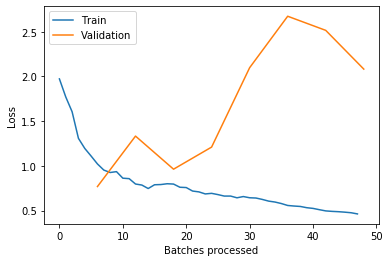

g18_224_lr_0.01_cyc_8_i6


Better model found at epoch 0 with accuracy value: 0.7149999737739563.


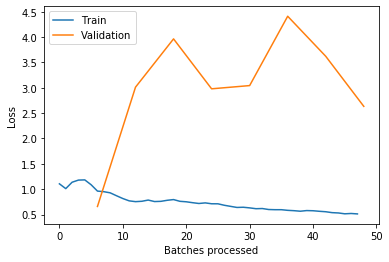

g18_224_lr_0.01_cyc_8_i7


Better model found at epoch 0 with accuracy value: 0.800000011920929.


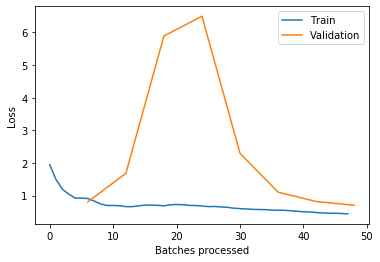

g18_224_lr_0.01_cyc_8_i8


Better model found at epoch 0 with accuracy value: 0.8149999976158142.


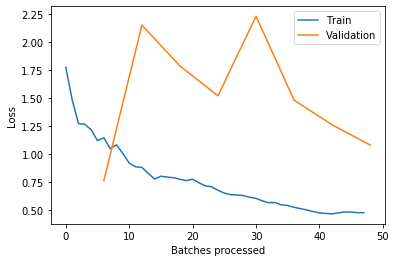

g18_224_lr_0.01_cyc_8_i9


Better model found at epoch 0 with accuracy value: 0.7799999713897705.
Better model found at epoch 5 with accuracy value: 0.8399999737739563.
Better model found at epoch 6 with accuracy value: 0.8600000143051147.
Better model found at epoch 7 with accuracy value: 0.8999999761581421.


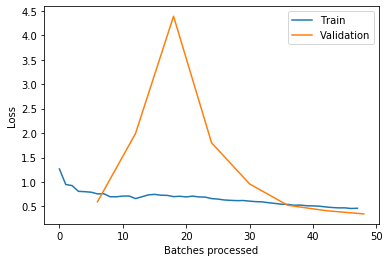

saved stats to: stats/g18_224_stats.p


In [30]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [31]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.100  med: 0.195   Loss -- best: 0.347  med: 0.657

g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.115   accuracy: 0.885   loss:0.3532
g18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.120   accuracy: 0.880   loss:0.5644
g18_224_lr_0.001_cyc_16_ps_0.5  error_rate: 0.130   accuracy: 0.870   loss:0.4836
g18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.135   accuracy: 0.865   loss:0.5309
g18_224_lr_0.001_cyc_16_ps_0.9  error_rate: 0.145   accuracy: 0.855   loss:0.5597
g18_224_lr_0.03_cyc_8  error_rate: 0.145   accuracy: 0.855   loss:0.6643
g18_224_lr_0.0003_cyc_16_ps_0.85  error_rate: 0.150   accuracy: 0.850   loss:0.4128
g18_224_lr_0.0003_cyc_16_ps_0.8  error_rate: 0.155   accuracy: 0.845   loss:0.4885


g18_224_lr_0.01_cyc_4_i0


Better model found at epoch 0 with accuracy value: 0.5299999713897705.
Better model found at epoch 1 with accuracy value: 0.625.
Better model found at epoch 2 with accuracy value: 0.7900000214576721.
Better model found at epoch 3 with accuracy value: 0.8349999785423279.


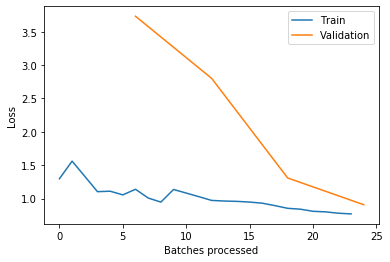

g18_224_lr_0.01_cyc_4_i1


Better model found at epoch 0 with accuracy value: 0.6399999856948853.


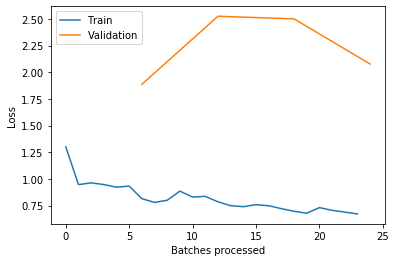

g18_224_lr_0.01_cyc_4_i2


Better model found at epoch 0 with accuracy value: 0.8399999737739563.


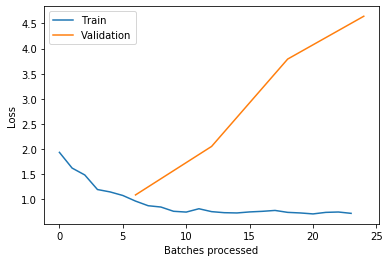

g18_224_lr_0.01_cyc_4_i3


Better model found at epoch 0 with accuracy value: 0.8199999928474426.


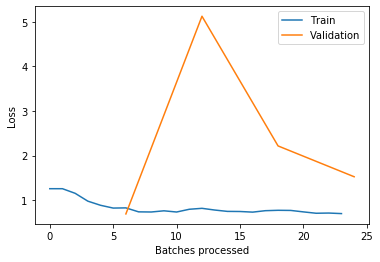

g18_224_lr_0.01_cyc_4_i4


Better model found at epoch 0 with accuracy value: 0.6200000047683716.
Better model found at epoch 2 with accuracy value: 0.8100000023841858.


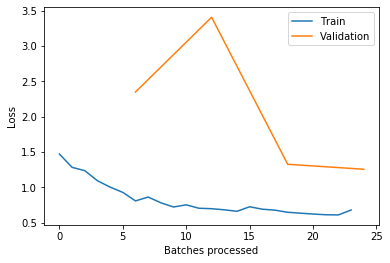

g18_224_lr_0.01_cyc_4_i5


Better model found at epoch 0 with accuracy value: 0.6650000214576721.
Better model found at epoch 1 with accuracy value: 0.6949999928474426.
Better model found at epoch 2 with accuracy value: 0.7749999761581421.


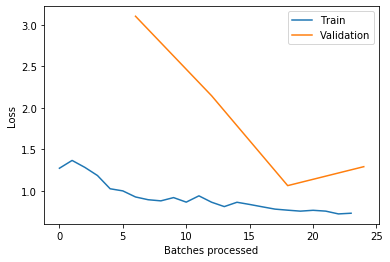

g18_224_lr_0.01_cyc_4_i6


Better model found at epoch 0 with accuracy value: 0.6899999976158142.


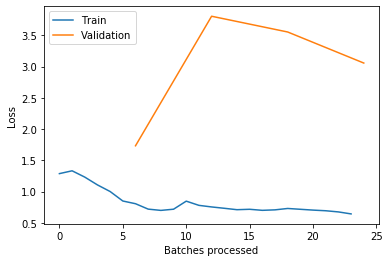

g18_224_lr_0.01_cyc_4_i7


Better model found at epoch 0 with accuracy value: 0.8299999833106995.


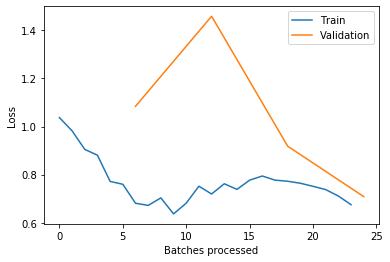

g18_224_lr_0.01_cyc_4_i8


Better model found at epoch 0 with accuracy value: 0.800000011920929.


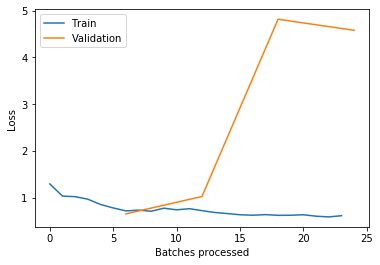

g18_224_lr_0.01_cyc_4_i9


Better model found at epoch 0 with accuracy value: 0.675000011920929.
Better model found at epoch 2 with accuracy value: 0.6899999976158142.


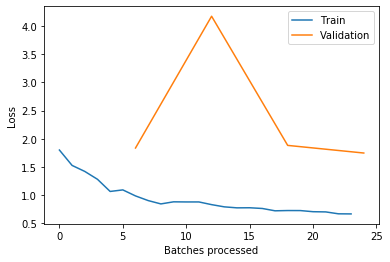

saved stats to: stats/g18_224_stats.p


In [32]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [33]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.100  med: 0.195   Loss -- best: 0.347  med: 0.699

g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.115   accuracy: 0.885   loss:0.3532
g18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.120   accuracy: 0.880   loss:0.5644
g18_224_lr_0.001_cyc_16_ps_0.5  error_rate: 0.130   accuracy: 0.870   loss:0.4836
g18_224_lr_0.001_cyc_16_ps_0.8  error_rate: 0.135   accuracy: 0.865   loss:0.5309
g18_224_lr_0.001_cyc_16_ps_0.9  error_rate: 0.145   accuracy: 0.855   loss:0.5597
g18_224_lr_0.03_cyc_8  error_rate: 0.145   accuracy: 0.855   loss:0.6643
g18_224_lr_0.0003_cyc_16_ps_0.85  error_rate: 0.150   accuracy: 0.850   loss:0.4128
g18_224_lr_0.0003_cyc_16_ps_0.8  error_rate: 0.155   accuracy: 0.845   loss:0.4885


g18_224_lr_0.01_cyc_12_i0


Better model found at epoch 0 with accuracy value: 0.7400000095367432.
Better model found at epoch 6 with accuracy value: 0.7599999904632568.
Better model found at epoch 8 with accuracy value: 0.824999988079071.
Better model found at epoch 9 with accuracy value: 0.8700000047683716.
Better model found at epoch 11 with accuracy value: 0.875.


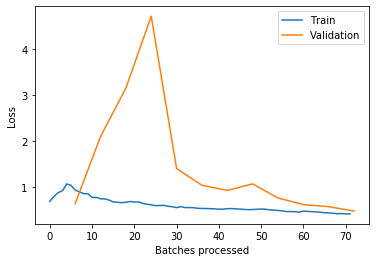

g18_224_lr_0.01_cyc_12_i1


Better model found at epoch 0 with accuracy value: 0.625.
Better model found at epoch 1 with accuracy value: 0.6700000166893005.
Better model found at epoch 7 with accuracy value: 0.7049999833106995.
Better model found at epoch 8 with accuracy value: 0.8149999976158142.
Better model found at epoch 9 with accuracy value: 0.8450000286102295.


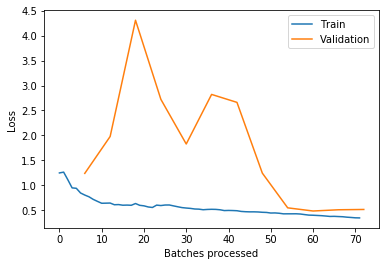

g18_224_lr_0.01_cyc_12_i2


Better model found at epoch 0 with accuracy value: 0.7649999856948853.
Better model found at epoch 5 with accuracy value: 0.800000011920929.
Better model found at epoch 11 with accuracy value: 0.8149999976158142.


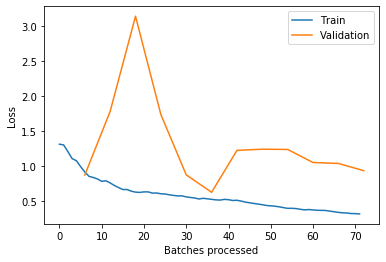

g18_224_lr_0.01_cyc_12_i3


Better model found at epoch 0 with accuracy value: 0.6549999713897705.
Better model found at epoch 1 with accuracy value: 0.7749999761581421.
Better model found at epoch 4 with accuracy value: 0.7799999713897705.
Better model found at epoch 5 with accuracy value: 0.800000011920929.
Better model found at epoch 6 with accuracy value: 0.8050000071525574.
Better model found at epoch 8 with accuracy value: 0.8399999737739563.
Better model found at epoch 11 with accuracy value: 0.8799999952316284.


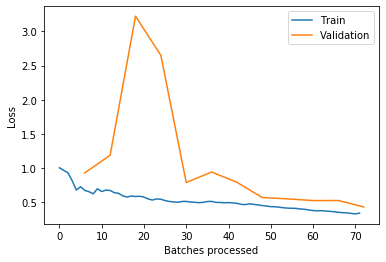

g18_224_lr_0.01_cyc_12_i4


Better model found at epoch 0 with accuracy value: 0.8149999976158142.
Better model found at epoch 6 with accuracy value: 0.8399999737739563.
Better model found at epoch 10 with accuracy value: 0.8600000143051147.
Better model found at epoch 11 with accuracy value: 0.8849999904632568.


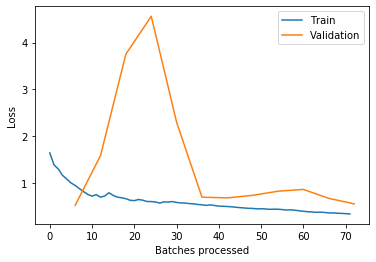

g18_224_lr_0.01_cyc_12_i5


Better model found at epoch 0 with accuracy value: 0.8199999928474426.
Better model found at epoch 2 with accuracy value: 0.8399999737739563.
Better model found at epoch 8 with accuracy value: 0.8700000047683716.


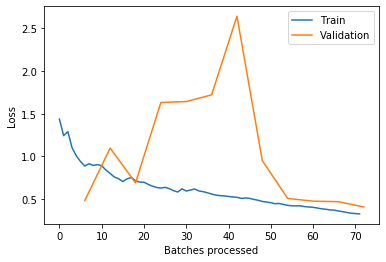

g18_224_lr_0.01_cyc_12_i6


Better model found at epoch 0 with accuracy value: 0.7950000166893005.
Better model found at epoch 1 with accuracy value: 0.824999988079071.
Better model found at epoch 9 with accuracy value: 0.8700000047683716.
Better model found at epoch 11 with accuracy value: 0.8899999856948853.


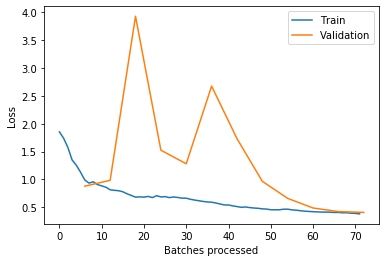

g18_224_lr_0.01_cyc_12_i7


Better model found at epoch 0 with accuracy value: 0.8399999737739563.
Better model found at epoch 7 with accuracy value: 0.8500000238418579.
Better model found at epoch 8 with accuracy value: 0.8799999952316284.
Better model found at epoch 10 with accuracy value: 0.8949999809265137.
Better model found at epoch 11 with accuracy value: 0.9049999713897705.


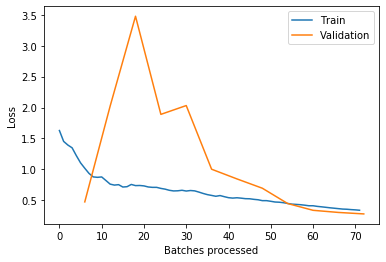

g18_224_lr_0.01_cyc_12_i8


Better model found at epoch 0 with accuracy value: 0.7549999952316284.
Better model found at epoch 3 with accuracy value: 0.8299999833106995.


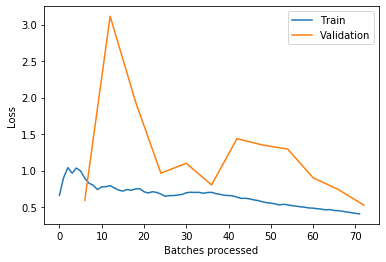

g18_224_lr_0.01_cyc_12_i9


Better model found at epoch 0 with accuracy value: 0.7950000166893005.
Better model found at epoch 2 with accuracy value: 0.8349999785423279.
Better model found at epoch 6 with accuracy value: 0.8399999737739563.
Better model found at epoch 7 with accuracy value: 0.8650000095367432.


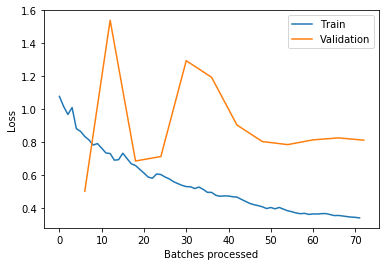

saved stats to: stats/g18_224_stats.p


In [34]:
for i in range(10):
    for key, params in get_params(all_cycles=[12], all_lr=[0.01]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [35]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.095  med: 0.185   Loss -- best: 0.277  med: 0.669

g18_224_lr_0.01_cyc_12_i7  error_rate: 0.095   accuracy: 0.905   loss:0.2771
g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.01_cyc_12_i6  error_rate: 0.110   accuracy: 0.890   loss:0.4106
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.115   accuracy: 0.885   loss:0.3532
g18_224_lr_0.01_cyc_12_i4  error_rate: 0.115   accuracy: 0.885   loss:0.5525
g18_224_lr_0.01_cyc_12_i3  error_rate: 0.120   accuracy: 0.880   loss:0.4299
g18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.120   accuracy: 0.880   loss:0.5644
g18_224_lr_0.01_cyc_12_i0  error_rate: 0.125   accuracy: 0.875   loss:0.4758
g18_224_lr_0.01_cyc_12_i5  error_rate: 0.130   accuracy: 0.870   loss:0.4085


g18_224_lr_0.02_cyc_8_i0


Better model found at epoch 0 with accuracy value: 0.8399999737739563.
Better model found at epoch 1 with accuracy value: 0.8799999952316284.


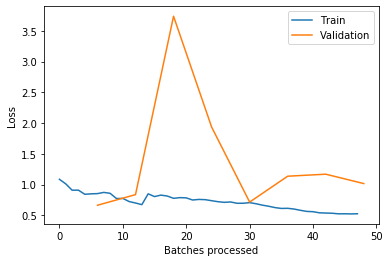

g18_224_lr_0.02_cyc_8_i1


Better model found at epoch 0 with accuracy value: 0.5049999952316284.
Better model found at epoch 1 with accuracy value: 0.6800000071525574.
Better model found at epoch 6 with accuracy value: 0.75.
Better model found at epoch 7 with accuracy value: 0.7850000262260437.


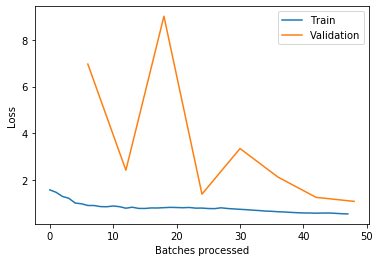

g18_224_lr_0.02_cyc_8_i2


Better model found at epoch 0 with accuracy value: 0.8299999833106995.


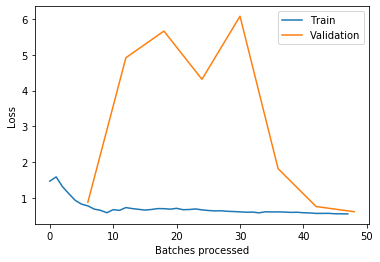

g18_224_lr_0.02_cyc_8_i3


Better model found at epoch 0 with accuracy value: 0.7749999761581421.
Better model found at epoch 1 with accuracy value: 0.7900000214576721.


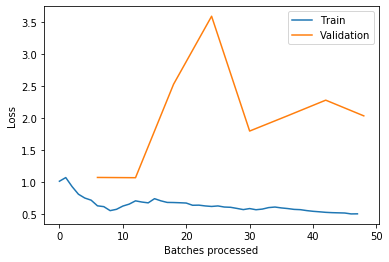

g18_224_lr_0.02_cyc_8_i4


Better model found at epoch 0 with accuracy value: 0.800000011920929.


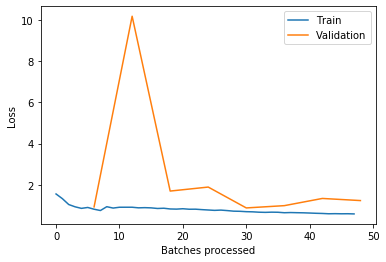

g18_224_lr_0.02_cyc_8_i5


Better model found at epoch 0 with accuracy value: 0.7450000047683716.
Better model found at epoch 6 with accuracy value: 0.8100000023841858.
Better model found at epoch 7 with accuracy value: 0.8299999833106995.


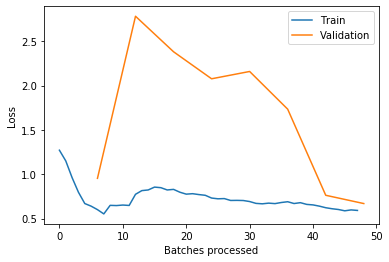

g18_224_lr_0.02_cyc_8_i6


Better model found at epoch 0 with accuracy value: 0.8550000190734863.


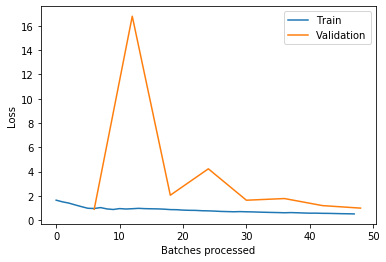

g18_224_lr_0.02_cyc_8_i7


Better model found at epoch 0 with accuracy value: 0.5199999809265137.
Better model found at epoch 1 with accuracy value: 0.699999988079071.
Better model found at epoch 4 with accuracy value: 0.7350000143051147.
Better model found at epoch 5 with accuracy value: 0.7599999904632568.


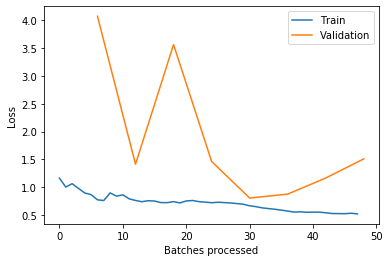

g18_224_lr_0.02_cyc_8_i8


Better model found at epoch 0 with accuracy value: 0.7950000166893005.


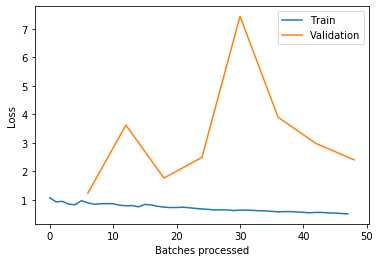

g18_224_lr_0.02_cyc_8_i9


Better model found at epoch 0 with accuracy value: 0.8450000286102295.


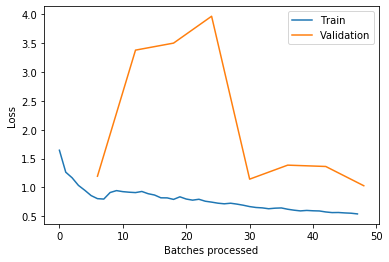

saved stats to: stats/g18_224_stats.p


In [36]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [37]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.095  med: 0.185   Loss -- best: 0.277  med: 0.710

g18_224_lr_0.01_cyc_12_i7  error_rate: 0.095   accuracy: 0.905   loss:0.2771
g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.01_cyc_12_i6  error_rate: 0.110   accuracy: 0.890   loss:0.4106
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.115   accuracy: 0.885   loss:0.3532
g18_224_lr_0.01_cyc_12_i4  error_rate: 0.115   accuracy: 0.885   loss:0.5525
g18_224_lr_0.01_cyc_12_i3  error_rate: 0.120   accuracy: 0.880   loss:0.4299
g18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.120   accuracy: 0.880   loss:0.5644
g18_224_lr_0.02_cyc_8_i0  error_rate: 0.120   accuracy: 0.880   loss:0.8355
g18_224_lr_0.01_cyc_12_i0  error_rate: 0.125   accuracy: 0.875   loss:0.4758


g18_224_lr_0.02_cyc_4_i0


Better model found at epoch 0 with accuracy value: 0.6899999976158142.


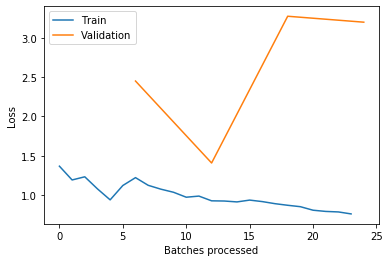

g18_224_lr_0.02_cyc_4_i1


Better model found at epoch 0 with accuracy value: 0.8050000071525574.


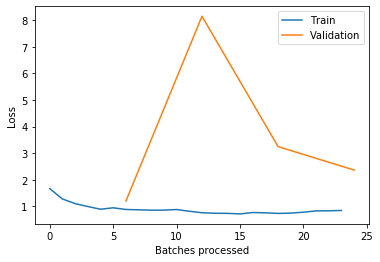

g18_224_lr_0.02_cyc_4_i2


Better model found at epoch 0 with accuracy value: 0.5550000071525574.
Better model found at epoch 1 with accuracy value: 0.8149999976158142.


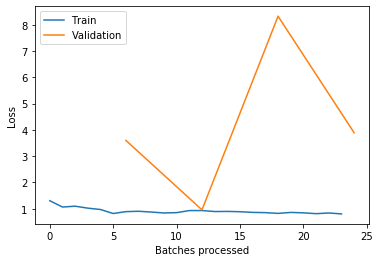

g18_224_lr_0.02_cyc_4_i3


Better model found at epoch 0 with accuracy value: 0.6349999904632568.


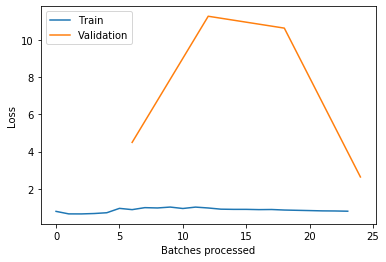

g18_224_lr_0.02_cyc_4_i4


Better model found at epoch 0 with accuracy value: 0.6149999499320984.
Better model found at epoch 1 with accuracy value: 0.6399999856948853.


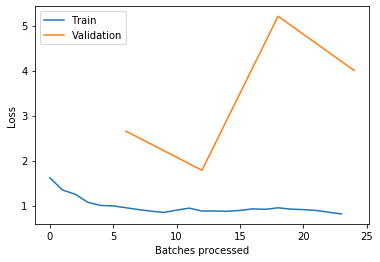

g18_224_lr_0.02_cyc_4_i5


Better model found at epoch 0 with accuracy value: 0.6000000238418579.


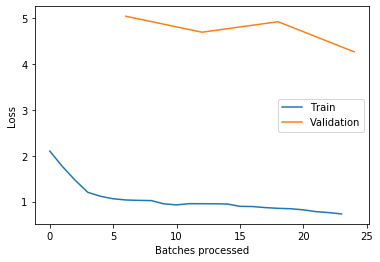

g18_224_lr_0.02_cyc_4_i6


Better model found at epoch 0 with accuracy value: 0.7649999856948853.
Better model found at epoch 2 with accuracy value: 0.7799999713897705.


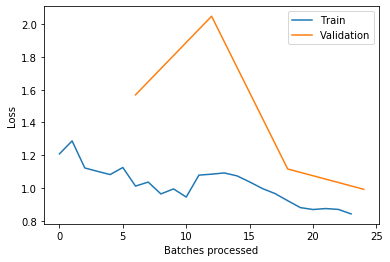

g18_224_lr_0.02_cyc_4_i7


Better model found at epoch 0 with accuracy value: 0.5249999761581421.
Better model found at epoch 1 with accuracy value: 0.6150000095367432.
Better model found at epoch 2 with accuracy value: 0.7300000190734863.


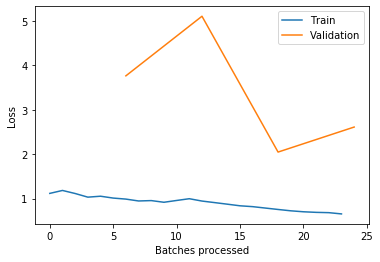

g18_224_lr_0.02_cyc_4_i8


Better model found at epoch 0 with accuracy value: 0.7099999785423279.
Better model found at epoch 3 with accuracy value: 0.8100000023841858.


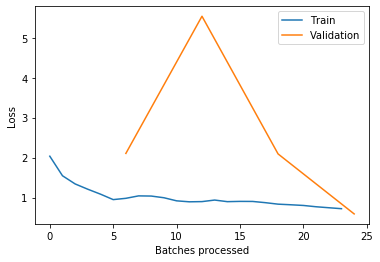

g18_224_lr_0.02_cyc_4_i9


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.6299999952316284.
Better model found at epoch 2 with accuracy value: 0.7749999761581421.


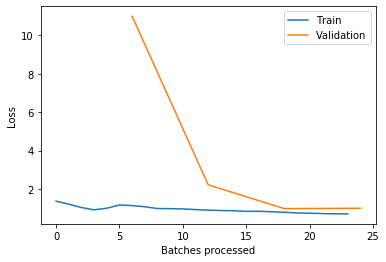

saved stats to: stats/g18_224_stats.p


In [38]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [39]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.095  med: 0.193   Loss -- best: 0.277  med: 0.786

g18_224_lr_0.01_cyc_12_i7  error_rate: 0.095   accuracy: 0.905   loss:0.2771
g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.01_cyc_12_i6  error_rate: 0.110   accuracy: 0.890   loss:0.4106
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.115   accuracy: 0.885   loss:0.3532
g18_224_lr_0.01_cyc_12_i4  error_rate: 0.115   accuracy: 0.885   loss:0.5525
g18_224_lr_0.01_cyc_12_i3  error_rate: 0.120   accuracy: 0.880   loss:0.4299
g18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.120   accuracy: 0.880   loss:0.5644
g18_224_lr_0.02_cyc_8_i0  error_rate: 0.120   accuracy: 0.880   loss:0.8355
g18_224_lr_0.01_cyc_12_i0  error_rate: 0.125   accuracy: 0.875   loss:0.4758


g18_224_lr_0.03_cyc_8_i0


Better model found at epoch 0 with accuracy value: 0.824999988079071.
Better model found at epoch 6 with accuracy value: 0.8349999785423279.
Better model found at epoch 7 with accuracy value: 0.8600000143051147.


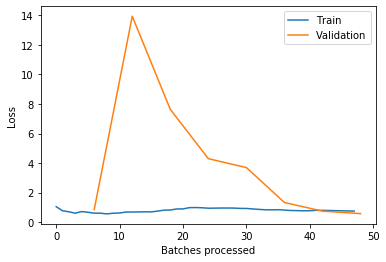

g18_224_lr_0.03_cyc_8_i1


Better model found at epoch 0 with accuracy value: 0.8199999928474426.


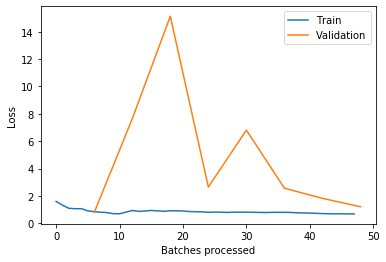

g18_224_lr_0.03_cyc_8_i2


Better model found at epoch 0 with accuracy value: 0.8450000286102295.


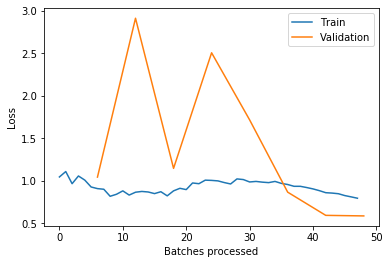

g18_224_lr_0.03_cyc_8_i3


Better model found at epoch 0 with accuracy value: 0.7450000047683716.
Better model found at epoch 4 with accuracy value: 0.7599999904632568.
Better model found at epoch 5 with accuracy value: 0.7699999809265137.
Better model found at epoch 6 with accuracy value: 0.8199999928474426.
Better model found at epoch 7 with accuracy value: 0.8299999833106995.


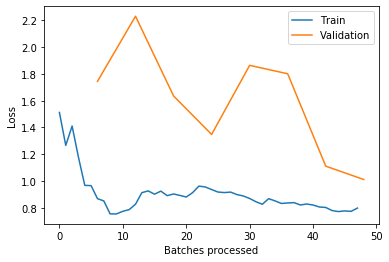

g18_224_lr_0.03_cyc_8_i4


Better model found at epoch 0 with accuracy value: 0.8100000023841858.
Better model found at epoch 5 with accuracy value: 0.8199999928474426.
Better model found at epoch 6 with accuracy value: 0.8349999785423279.
Better model found at epoch 7 with accuracy value: 0.8450000286102295.


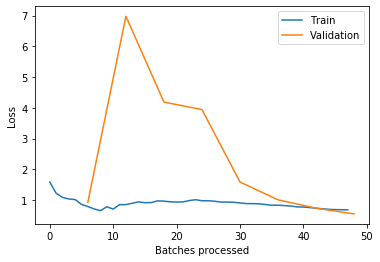

g18_224_lr_0.03_cyc_8_i5


Better model found at epoch 0 with accuracy value: 0.6700000166893005.
Better model found at epoch 4 with accuracy value: 0.7749999761581421.


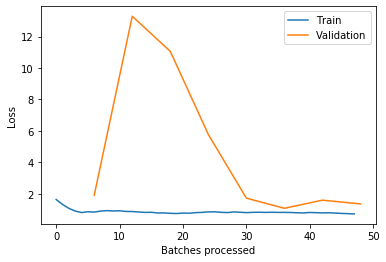

g18_224_lr_0.03_cyc_8_i6


Better model found at epoch 0 with accuracy value: 0.6399999856948853.
Better model found at epoch 2 with accuracy value: 0.699999988079071.
Better model found at epoch 7 with accuracy value: 0.7699999809265137.


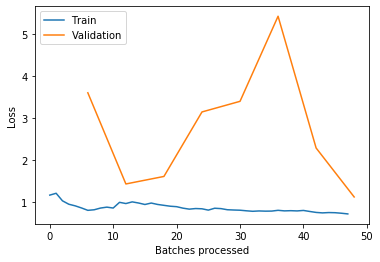

g18_224_lr_0.03_cyc_8_i7


Better model found at epoch 0 with accuracy value: 0.7049999833106995.
Better model found at epoch 4 with accuracy value: 0.7749999761581421.
Better model found at epoch 5 with accuracy value: 0.8299999833106995.


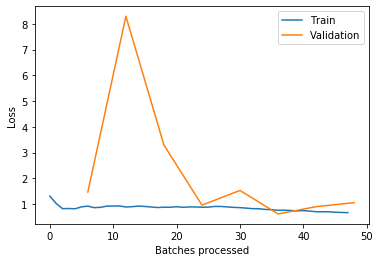

g18_224_lr_0.03_cyc_8_i8


Better model found at epoch 0 with accuracy value: 0.7200000286102295.
Better model found at epoch 6 with accuracy value: 0.8349999785423279.
Better model found at epoch 7 with accuracy value: 0.875.


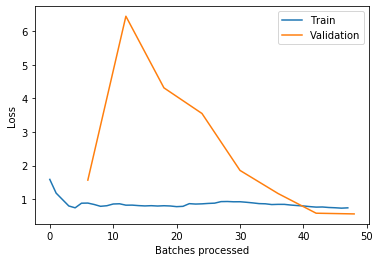

g18_224_lr_0.03_cyc_8_i9


Better model found at epoch 0 with accuracy value: 0.6449999809265137.
Better model found at epoch 1 with accuracy value: 0.6700000166893005.
Better model found at epoch 3 with accuracy value: 0.7300000190734863.
Better model found at epoch 4 with accuracy value: 0.7599999904632568.
Better model found at epoch 5 with accuracy value: 0.8450000286102295.


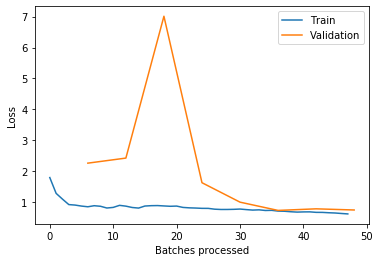

saved stats to: stats/g18_224_stats.p


In [40]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [41]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.095  med: 0.185   Loss -- best: 0.277  med: 0.778

g18_224_lr_0.01_cyc_12_i7  error_rate: 0.095   accuracy: 0.905   loss:0.2771
g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.01_cyc_12_i6  error_rate: 0.110   accuracy: 0.890   loss:0.4106
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.115   accuracy: 0.885   loss:0.3532
g18_224_lr_0.01_cyc_12_i4  error_rate: 0.115   accuracy: 0.885   loss:0.5525
g18_224_lr_0.01_cyc_12_i3  error_rate: 0.120   accuracy: 0.880   loss:0.4299
g18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.120   accuracy: 0.880   loss:0.5644
g18_224_lr_0.02_cyc_8_i0  error_rate: 0.120   accuracy: 0.880   loss:0.8355
g18_224_lr_0.01_cyc_12_i0  error_rate: 0.125   accuracy: 0.875   loss:0.4758


g18_224_lr_0.03_cyc_4_i0


Better model found at epoch 0 with accuracy value: 0.5699999928474426.
Better model found at epoch 1 with accuracy value: 0.5799999833106995.


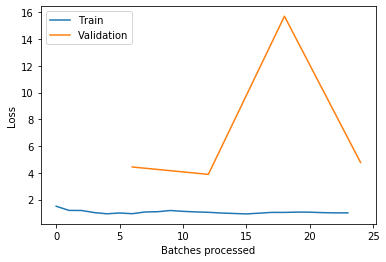

g18_224_lr_0.03_cyc_4_i1


Better model found at epoch 0 with accuracy value: 0.8100000023841858.


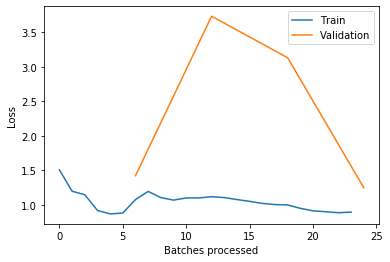

g18_224_lr_0.03_cyc_4_i2


Better model found at epoch 0 with accuracy value: 0.5950000286102295.
Better model found at epoch 2 with accuracy value: 0.699999988079071.
Better model found at epoch 3 with accuracy value: 0.7850000262260437.


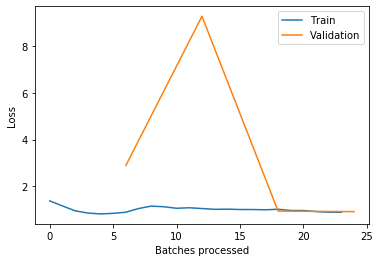

g18_224_lr_0.03_cyc_4_i3


Better model found at epoch 0 with accuracy value: 0.5950000286102295.
Better model found at epoch 3 with accuracy value: 0.6050000190734863.


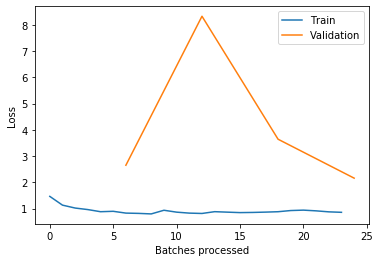

g18_224_lr_0.03_cyc_4_i4


Better model found at epoch 0 with accuracy value: 0.7900000214576721.


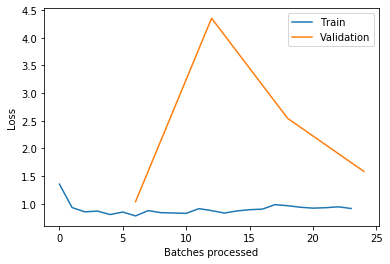

g18_224_lr_0.03_cyc_4_i5


Better model found at epoch 0 with accuracy value: 0.8399999737739563.


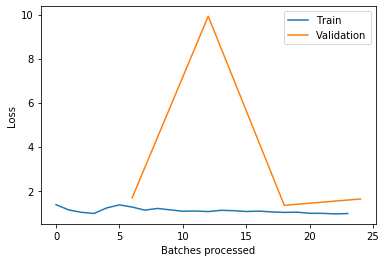

g18_224_lr_0.03_cyc_4_i6


Better model found at epoch 0 with accuracy value: 0.5249999761581421.
Better model found at epoch 1 with accuracy value: 0.7149999737739563.


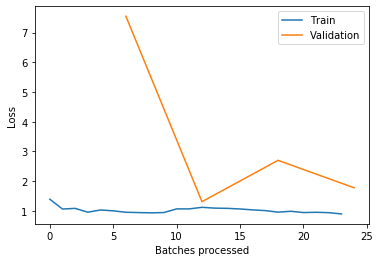

g18_224_lr_0.03_cyc_4_i7


Better model found at epoch 0 with accuracy value: 0.5849999785423279.
Better model found at epoch 2 with accuracy value: 0.699999988079071.
Better model found at epoch 3 with accuracy value: 0.7900000214576721.


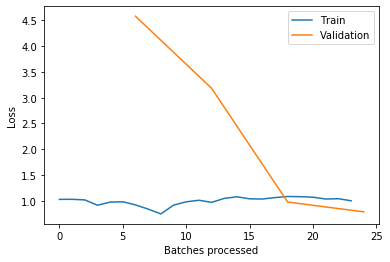

g18_224_lr_0.03_cyc_4_i8


Better model found at epoch 0 with accuracy value: 0.7450000047683716.


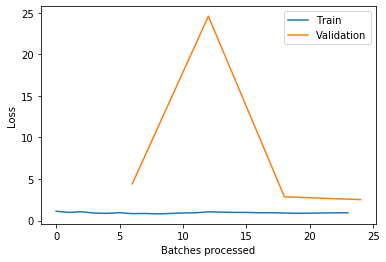

g18_224_lr_0.03_cyc_4_i9


Better model found at epoch 0 with accuracy value: 0.675000011920929.
Better model found at epoch 1 with accuracy value: 0.7200000286102295.
Better model found at epoch 2 with accuracy value: 0.8100000023841858.
Better model found at epoch 3 with accuracy value: 0.824999988079071.


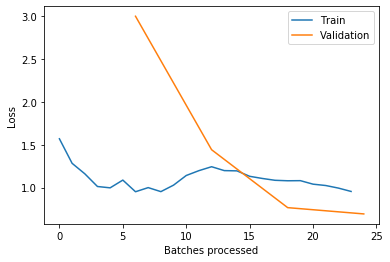

saved stats to: stats/g18_224_stats.p


In [42]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, **params)
all_stats.save()

In [43]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.095  med: 0.190   Loss -- best: 0.277  med: 0.807

g18_224_lr_0.01_cyc_12_i7  error_rate: 0.095   accuracy: 0.905   loss:0.2771
g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.01_cyc_12_i6  error_rate: 0.110   accuracy: 0.890   loss:0.4106
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.115   accuracy: 0.885   loss:0.3532
g18_224_lr_0.01_cyc_12_i4  error_rate: 0.115   accuracy: 0.885   loss:0.5525
g18_224_lr_0.01_cyc_12_i3  error_rate: 0.120   accuracy: 0.880   loss:0.4299
g18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.120   accuracy: 0.880   loss:0.5644
g18_224_lr_0.02_cyc_8_i0  error_rate: 0.120   accuracy: 0.880   loss:0.8355
g18_224_lr_0.01_cyc_12_i0  error_rate: 0.125   accuracy: 0.875   loss:0.4758


g18_224_lr_0.02_cyc_8_i0_m


Better model found at epoch 0 with accuracy value: 0.5149999856948853.
Better model found at epoch 2 with accuracy value: 0.625.
Better model found at epoch 3 with accuracy value: 0.75.
Better model found at epoch 5 with accuracy value: 0.7699999809265137.
Better model found at epoch 7 with accuracy value: 0.7900000214576721.


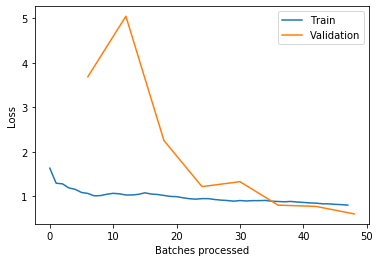

g18_224_lr_0.02_cyc_8_i1_m


Better model found at epoch 0 with accuracy value: 0.8149999976158142.
Better model found at epoch 6 with accuracy value: 0.8500000238418579.
Better model found at epoch 7 with accuracy value: 0.8650000095367432.


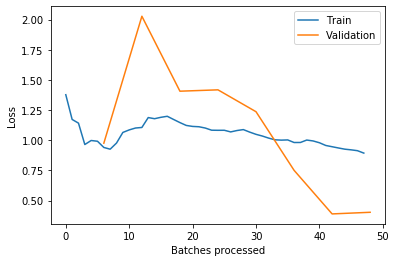

g18_224_lr_0.02_cyc_8_i2_m


Better model found at epoch 0 with accuracy value: 0.7950000166893005.
Better model found at epoch 6 with accuracy value: 0.8299999833106995.


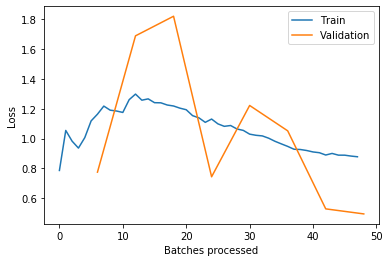

g18_224_lr_0.02_cyc_8_i3_m


Better model found at epoch 0 with accuracy value: 0.7649999856948853.
Better model found at epoch 5 with accuracy value: 0.7799999713897705.


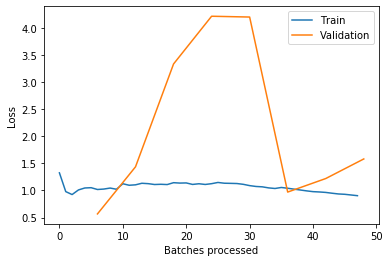

g18_224_lr_0.02_cyc_8_i4_m


Better model found at epoch 0 with accuracy value: 0.7350000143051147.
Better model found at epoch 4 with accuracy value: 0.7950000166893005.
Better model found at epoch 6 with accuracy value: 0.800000011920929.
Better model found at epoch 7 with accuracy value: 0.8199999928474426.


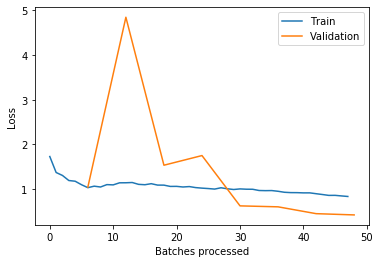

g18_224_lr_0.02_cyc_8_i5_m


Better model found at epoch 0 with accuracy value: 0.8100000023841858.


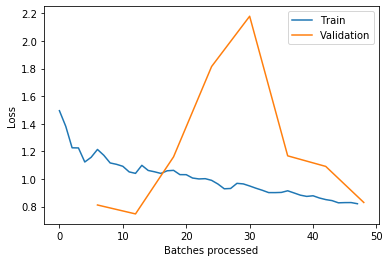

g18_224_lr_0.02_cyc_8_i6_m


Better model found at epoch 0 with accuracy value: 0.7300000190734863.


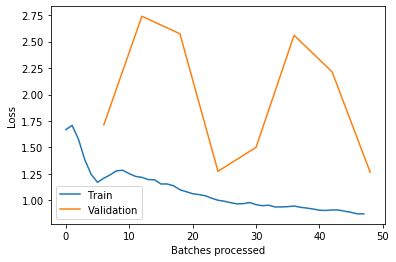

g18_224_lr_0.02_cyc_8_i7_m


Better model found at epoch 0 with accuracy value: 0.5450000166893005.
Better model found at epoch 2 with accuracy value: 0.5799999833106995.
Better model found at epoch 3 with accuracy value: 0.7900000214576721.
Better model found at epoch 4 with accuracy value: 0.8600000143051147.


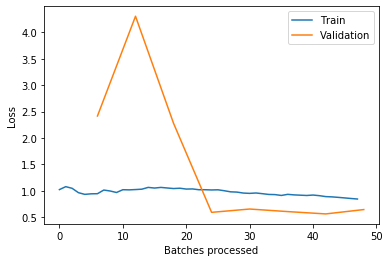

g18_224_lr_0.02_cyc_8_i8_m


Better model found at epoch 0 with accuracy value: 0.4950000047683716.
Better model found at epoch 1 with accuracy value: 0.6800000071525574.
Better model found at epoch 6 with accuracy value: 0.7099999785423279.
Better model found at epoch 7 with accuracy value: 0.7950000166893005.


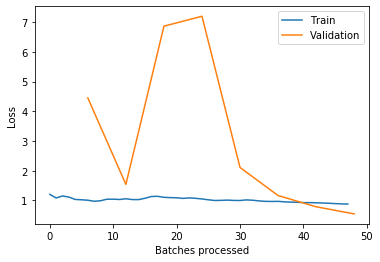

g18_224_lr_0.02_cyc_8_i9_m


Better model found at epoch 0 with accuracy value: 0.5400000214576721.
Better model found at epoch 1 with accuracy value: 0.5450000166893005.
Better model found at epoch 2 with accuracy value: 0.6000000238418579.
Better model found at epoch 3 with accuracy value: 0.7250000238418579.
Better model found at epoch 6 with accuracy value: 0.7649999856948853.
Better model found at epoch 7 with accuracy value: 0.8050000071525574.


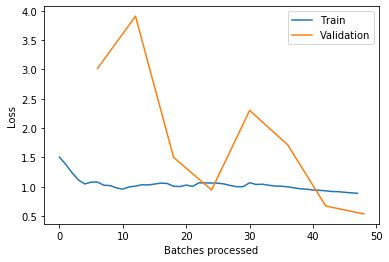

saved stats to: stats/g18_224_stats.p


In [44]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [45]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.095  med: 0.190   Loss -- best: 0.277  med: 0.796

g18_224_lr_0.01_cyc_12_i7  error_rate: 0.095   accuracy: 0.905   loss:0.2771
g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.01_cyc_12_i6  error_rate: 0.110   accuracy: 0.890   loss:0.4106
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.0003_cyc_16_ps_0.9  error_rate: 0.115   accuracy: 0.885   loss:0.3532
g18_224_lr_0.01_cyc_12_i4  error_rate: 0.115   accuracy: 0.885   loss:0.5525
g18_224_lr_0.01_cyc_12_i3  error_rate: 0.120   accuracy: 0.880   loss:0.4299
g18_224_lr_0.001_cyc_16_ps_0.85  error_rate: 0.120   accuracy: 0.880   loss:0.5644
g18_224_lr_0.02_cyc_8_i0  error_rate: 0.120   accuracy: 0.880   loss:0.8355
g18_224_lr_0.01_cyc_12_i0  error_rate: 0.125   accuracy: 0.875   loss:0.4758


g18_224_lr_0.02_cyc_16_i0_m


Better model found at epoch 0 with accuracy value: 0.7549999952316284.
Better model found at epoch 6 with accuracy value: 0.7799999713897705.
Better model found at epoch 8 with accuracy value: 0.8500000238418579.
Better model found at epoch 11 with accuracy value: 0.8600000143051147.
Better model found at epoch 12 with accuracy value: 0.8949999809265137.
Better model found at epoch 13 with accuracy value: 0.9150000214576721.
Better model found at epoch 14 with accuracy value: 0.925000011920929.


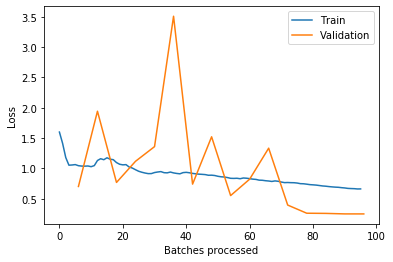

g18_224_lr_0.02_cyc_16_i1_m


Better model found at epoch 0 with accuracy value: 0.7900000214576721.
Better model found at epoch 8 with accuracy value: 0.824999988079071.
Better model found at epoch 9 with accuracy value: 0.8450000286102295.
Better model found at epoch 12 with accuracy value: 0.8700000047683716.
Better model found at epoch 13 with accuracy value: 0.8949999809265137.


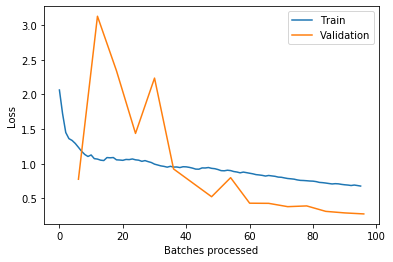

g18_224_lr_0.02_cyc_16_i2_m


Better model found at epoch 0 with accuracy value: 0.8050000071525574.
Better model found at epoch 11 with accuracy value: 0.8450000286102295.
Better model found at epoch 12 with accuracy value: 0.8799999952316284.


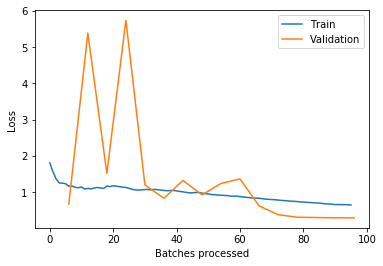

g18_224_lr_0.02_cyc_16_i3_m


Better model found at epoch 0 with accuracy value: 0.6600000262260437.
Better model found at epoch 2 with accuracy value: 0.6949999928474426.
Better model found at epoch 5 with accuracy value: 0.7200000286102295.
Better model found at epoch 7 with accuracy value: 0.800000011920929.
Better model found at epoch 8 with accuracy value: 0.8799999952316284.


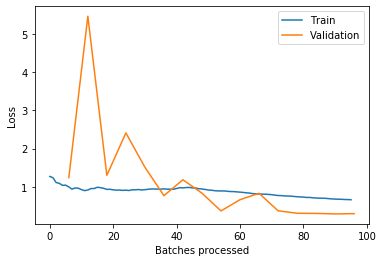

g18_224_lr_0.02_cyc_16_i4_m


Better model found at epoch 0 with accuracy value: 0.800000011920929.
Better model found at epoch 10 with accuracy value: 0.8550000190734863.
Better model found at epoch 14 with accuracy value: 0.8799999952316284.


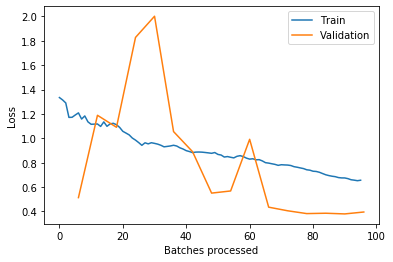

g18_224_lr_0.02_cyc_16_i5_m


Better model found at epoch 0 with accuracy value: 0.8299999833106995.
Better model found at epoch 9 with accuracy value: 0.8450000286102295.
Better model found at epoch 10 with accuracy value: 0.875.
Better model found at epoch 11 with accuracy value: 0.8899999856948853.


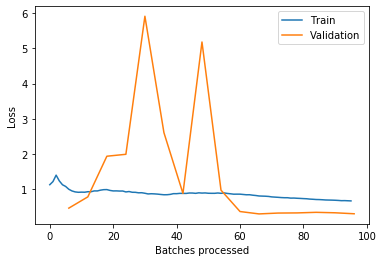

g18_224_lr_0.02_cyc_16_i6_m


Better model found at epoch 0 with accuracy value: 0.6650000214576721.
Better model found at epoch 1 with accuracy value: 0.7549999952316284.
Better model found at epoch 2 with accuracy value: 0.800000011920929.
Better model found at epoch 8 with accuracy value: 0.8349999785423279.
Better model found at epoch 10 with accuracy value: 0.8550000190734863.
Better model found at epoch 15 with accuracy value: 0.8700000047683716.


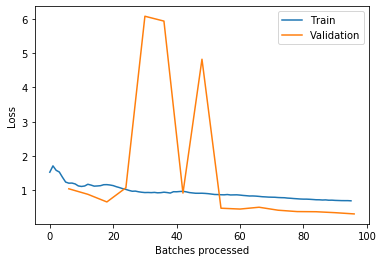

g18_224_lr_0.02_cyc_16_i7_m


Better model found at epoch 0 with accuracy value: 0.8050000071525574.
Better model found at epoch 10 with accuracy value: 0.8299999833106995.
Better model found at epoch 11 with accuracy value: 0.8799999952316284.
Better model found at epoch 12 with accuracy value: 0.8849999904632568.


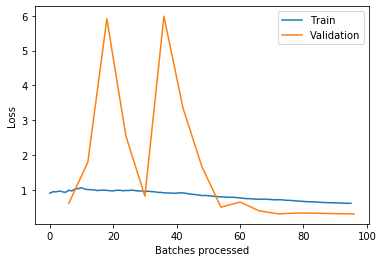

g18_224_lr_0.02_cyc_16_i8_m


Better model found at epoch 0 with accuracy value: 0.7850000262260437.
Better model found at epoch 6 with accuracy value: 0.8399999737739563.
Better model found at epoch 12 with accuracy value: 0.875.
Better model found at epoch 13 with accuracy value: 0.8999999761581421.
Better model found at epoch 15 with accuracy value: 0.9049999713897705.


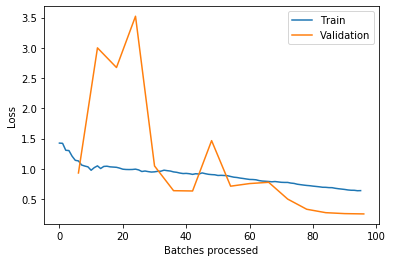

g18_224_lr_0.02_cyc_16_i9_m


Better model found at epoch 0 with accuracy value: 0.5249999761581421.
Better model found at epoch 1 with accuracy value: 0.5550000071525574.
Better model found at epoch 2 with accuracy value: 0.7250000238418579.
Better model found at epoch 10 with accuracy value: 0.7699999809265137.
Better model found at epoch 11 with accuracy value: 0.824999988079071.
Better model found at epoch 12 with accuracy value: 0.8700000047683716.
Better model found at epoch 13 with accuracy value: 0.8849999904632568.


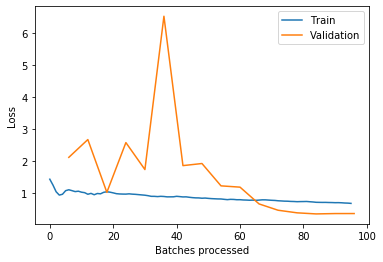

saved stats to: stats/g18_224_stats.p


In [46]:
for i in range(10):
    for key, params in get_params(all_cycles=[16], all_lr=[0.02]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [47]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.075  med: 0.185   Loss -- best: 0.250  med: 0.743

g18_224_lr_0.02_cyc_16_i0_m  error_rate: 0.075   accuracy: 0.925   loss:0.2497
g18_224_lr_0.01_cyc_12_i7  error_rate: 0.095   accuracy: 0.905   loss:0.2771
g18_224_lr_0.02_cyc_16_i8_m  error_rate: 0.095   accuracy: 0.905   loss:0.2541
g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.105   accuracy: 0.895   loss:0.3121
g18_224_lr_0.01_cyc_12_i6  error_rate: 0.110   accuracy: 0.890   loss:0.4106
g18_224_lr_0.02_cyc_16_i5_m  error_rate: 0.110   accuracy: 0.890   loss:0.3248
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.02_cyc_16_i7_m  error_rate: 0.115   accuracy: 0.885   loss:0.3384
g18_224_lr_0.02_cyc_16_i9_m  error_rate: 0.115   accuracy: 0.885   loss:0.3485


g18_224_lr_0.03_cyc_8_i0_m


Better model found at epoch 0 with accuracy value: 0.675000011920929.
Better model found at epoch 5 with accuracy value: 0.6899999976158142.
Better model found at epoch 6 with accuracy value: 0.7850000262260437.
Better model found at epoch 7 with accuracy value: 0.8149999976158142.


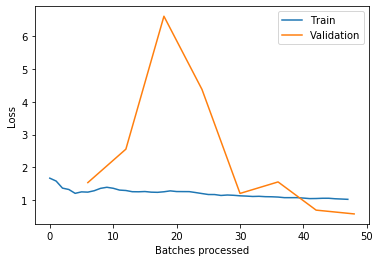

g18_224_lr_0.03_cyc_8_i1_m


Better model found at epoch 0 with accuracy value: 0.7400000095367432.
Better model found at epoch 7 with accuracy value: 0.7450000047683716.


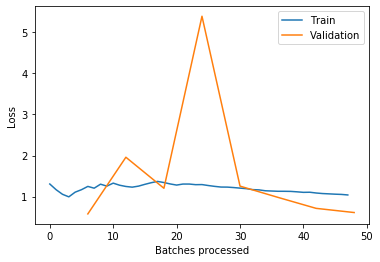

g18_224_lr_0.03_cyc_8_i2_m


Better model found at epoch 0 with accuracy value: 0.824999988079071.


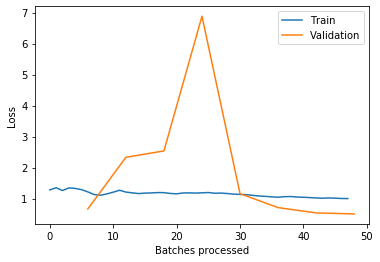

g18_224_lr_0.03_cyc_8_i3_m


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.574999988079071.
Better model found at epoch 4 with accuracy value: 0.7149999737739563.


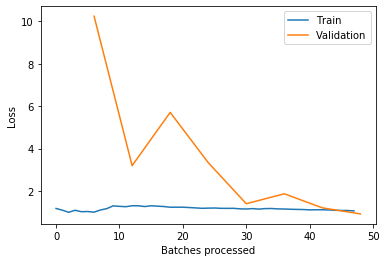

g18_224_lr_0.03_cyc_8_i4_m


Better model found at epoch 0 with accuracy value: 0.800000011920929.


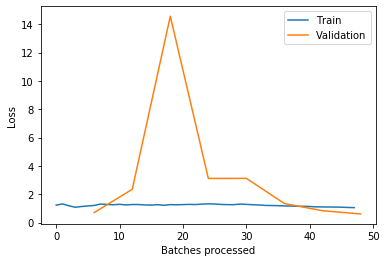

g18_224_lr_0.03_cyc_8_i5_m


Better model found at epoch 0 with accuracy value: 0.6650000214576721.
Better model found at epoch 7 with accuracy value: 0.7549999952316284.


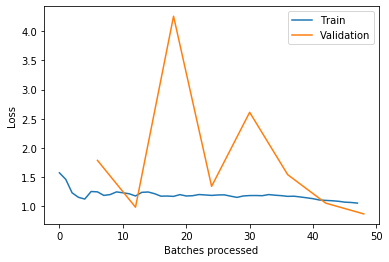

g18_224_lr_0.03_cyc_8_i6_m


Better model found at epoch 0 with accuracy value: 0.7549999952316284.


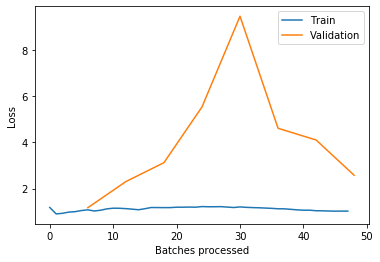

g18_224_lr_0.03_cyc_8_i7_m


Better model found at epoch 0 with accuracy value: 0.7900000214576721.
Better model found at epoch 5 with accuracy value: 0.800000011920929.
Better model found at epoch 6 with accuracy value: 0.824999988079071.
Better model found at epoch 7 with accuracy value: 0.8399999737739563.


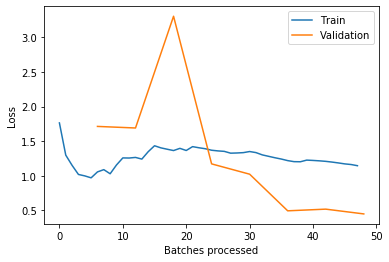

g18_224_lr_0.03_cyc_8_i8_m


Better model found at epoch 0 with accuracy value: 0.6449999809265137.
Better model found at epoch 3 with accuracy value: 0.699999988079071.
Better model found at epoch 5 with accuracy value: 0.7749999761581421.


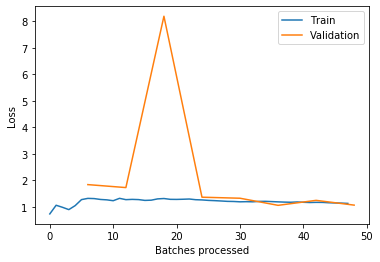

g18_224_lr_0.03_cyc_8_i9_m


Better model found at epoch 0 with accuracy value: 0.7749999761581421.
Better model found at epoch 6 with accuracy value: 0.8299999833106995.
Better model found at epoch 7 with accuracy value: 0.8399999737739563.


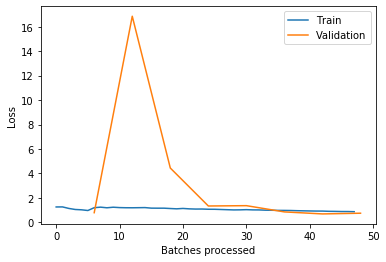

saved stats to: stats/g18_224_stats.p


In [48]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[0.03]):
        key = f'{key}_i{i}'
        do_train(key, mixup=True, **params)
all_stats.save()

In [49]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.075  med: 0.185   Loss -- best: 0.250  med: 0.742

g18_224_lr_0.02_cyc_16_i0_m  error_rate: 0.075   accuracy: 0.925   loss:0.2497
g18_224_lr_0.01_cyc_12_i7  error_rate: 0.095   accuracy: 0.905   loss:0.2771
g18_224_lr_0.02_cyc_16_i8_m  error_rate: 0.095   accuracy: 0.905   loss:0.2541
g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.105   accuracy: 0.895   loss:0.3121
g18_224_lr_0.01_cyc_12_i6  error_rate: 0.110   accuracy: 0.890   loss:0.4106
g18_224_lr_0.02_cyc_16_i5_m  error_rate: 0.110   accuracy: 0.890   loss:0.3248
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.02_cyc_16_i7_m  error_rate: 0.115   accuracy: 0.885   loss:0.3384
g18_224_lr_0.02_cyc_16_i9_m  error_rate: 0.115   accuracy: 0.885   loss:0.3485


g18_224_lr_0.003_cyc_4_i0_ls


Better model found at epoch 0 with accuracy value: 0.5249999761581421.
Better model found at epoch 1 with accuracy value: 0.7049999833106995.
Better model found at epoch 2 with accuracy value: 0.7599999904632568.
Better model found at epoch 3 with accuracy value: 0.7900000214576721.


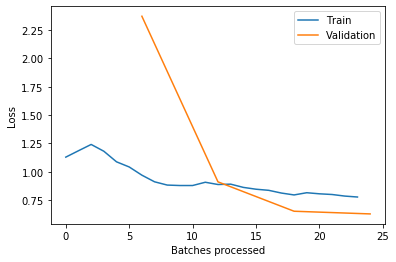

g18_224_lr_0.001_cyc_4_i0_ls


Better model found at epoch 0 with accuracy value: 0.574999988079071.
Better model found at epoch 1 with accuracy value: 0.7400000095367432.


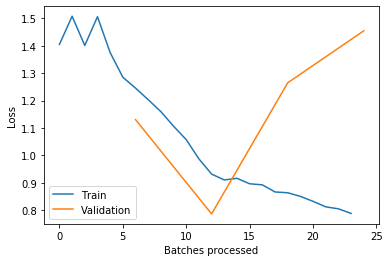

g18_224_lr_0.003_cyc_4_i1_ls


Better model found at epoch 0 with accuracy value: 0.7049999833106995.
Better model found at epoch 1 with accuracy value: 0.8050000071525574.
Better model found at epoch 3 with accuracy value: 0.8100000023841858.


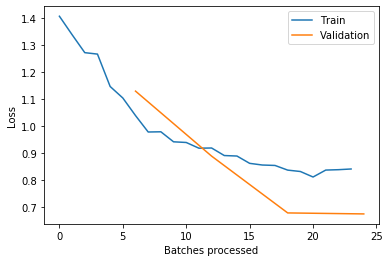

g18_224_lr_0.001_cyc_4_i1_ls


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.5049999952316284.
Better model found at epoch 2 with accuracy value: 0.5099999904632568.
Better model found at epoch 3 with accuracy value: 0.5149999856948853.


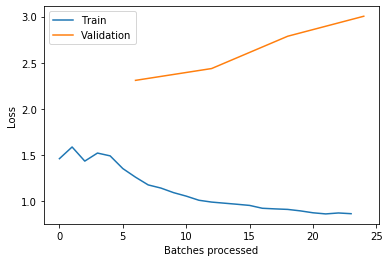

g18_224_lr_0.003_cyc_4_i2_ls


Better model found at epoch 0 with accuracy value: 0.8149999976158142.


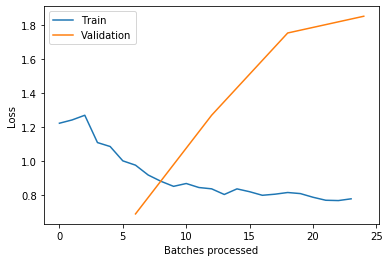

g18_224_lr_0.001_cyc_4_i2_ls


Better model found at epoch 0 with accuracy value: 0.6499999761581421.
Better model found at epoch 1 with accuracy value: 0.8100000023841858.


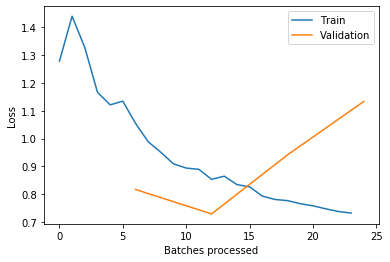

g18_224_lr_0.003_cyc_4_i3_ls


Better model found at epoch 0 with accuracy value: 0.7900000214576721.


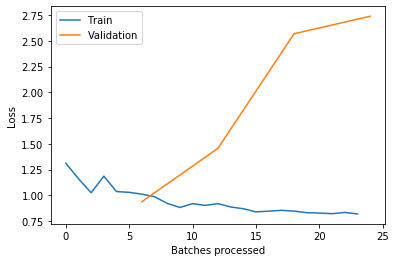

g18_224_lr_0.001_cyc_4_i3_ls


Better model found at epoch 0 with accuracy value: 0.6200000047683716.
Better model found at epoch 1 with accuracy value: 0.7049999833106995.


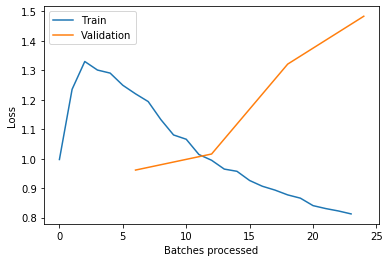

g18_224_lr_0.003_cyc_4_i4_ls


Better model found at epoch 0 with accuracy value: 0.8299999833106995.


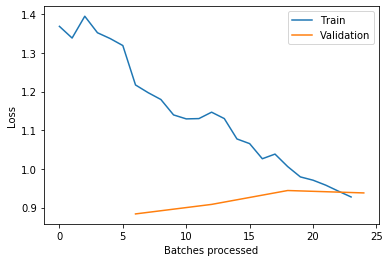

g18_224_lr_0.001_cyc_4_i4_ls


Better model found at epoch 0 with accuracy value: 0.6399999856948853.
Better model found at epoch 1 with accuracy value: 0.8299999833106995.


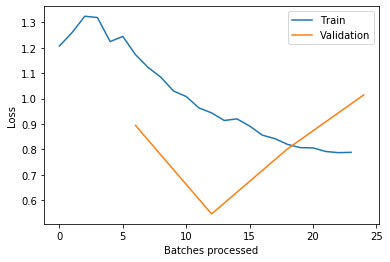

g18_224_lr_0.003_cyc_4_i5_ls


Better model found at epoch 0 with accuracy value: 0.7749999761581421.


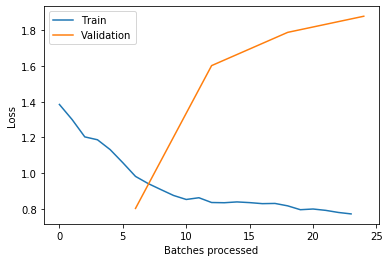

g18_224_lr_0.001_cyc_4_i5_ls


Better model found at epoch 0 with accuracy value: 0.6949999928474426.
Better model found at epoch 1 with accuracy value: 0.8100000023841858.


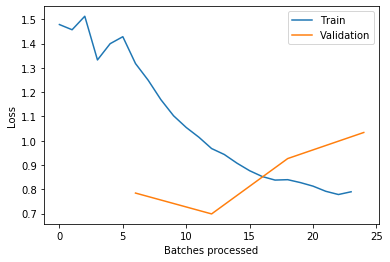

g18_224_lr_0.003_cyc_4_i6_ls


Better model found at epoch 0 with accuracy value: 0.6600000262260437.
Better model found at epoch 1 with accuracy value: 0.8100000023841858.


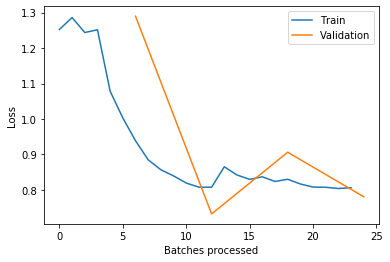

g18_224_lr_0.001_cyc_4_i6_ls


Better model found at epoch 0 with accuracy value: 0.6949999928474426.
Better model found at epoch 1 with accuracy value: 0.7649999856948853.


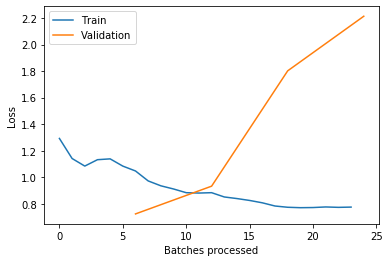

g18_224_lr_0.003_cyc_4_i7_ls


Better model found at epoch 0 with accuracy value: 0.7850000262260437.


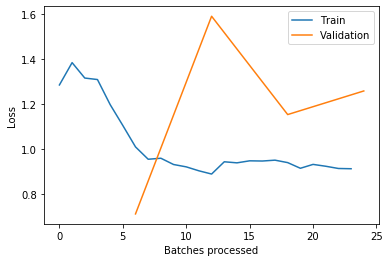

g18_224_lr_0.001_cyc_4_i7_ls


Better model found at epoch 0 with accuracy value: 0.6800000071525574.


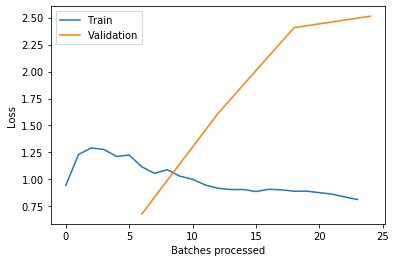

g18_224_lr_0.003_cyc_4_i8_ls


Better model found at epoch 0 with accuracy value: 0.7250000238418579.


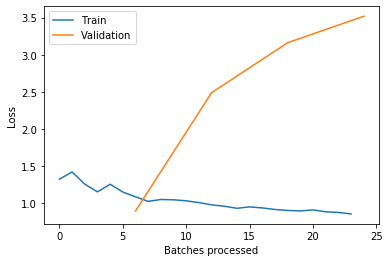

g18_224_lr_0.001_cyc_4_i8_ls


Better model found at epoch 0 with accuracy value: 0.5950000286102295.
Better model found at epoch 1 with accuracy value: 0.8100000023841858.


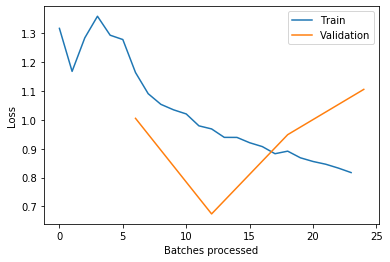

g18_224_lr_0.003_cyc_4_i9_ls


Better model found at epoch 0 with accuracy value: 0.8050000071525574.


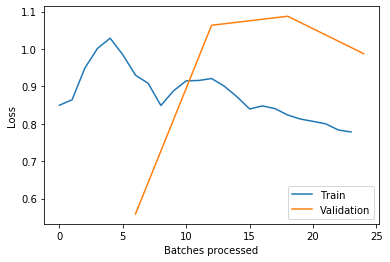

g18_224_lr_0.001_cyc_4_i9_ls


Better model found at epoch 0 with accuracy value: 0.7699999809265137.


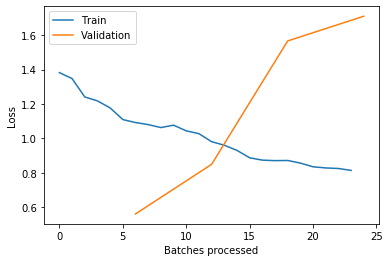

saved stats to: stats/g18_224_stats.p


In [50]:
for i in range(10):
    for key, params in get_params(all_cycles=[4], all_lr=[3e-3, 1e-3]):
        key = f'{key}_i{i}'
        do_train_ls(key, **params)
all_stats.save()

g18_224_lr_0.003_cyc_8_i0_ls


Better model found at epoch 0 with accuracy value: 0.8299999833106995.
Better model found at epoch 7 with accuracy value: 0.8349999785423279.


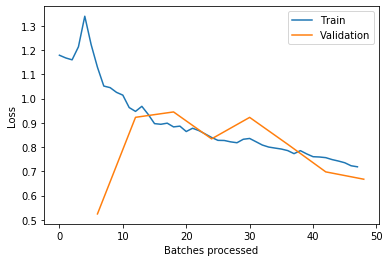

g18_224_lr_0.001_cyc_8_i0_ls


Better model found at epoch 0 with accuracy value: 0.6100000143051147.
Better model found at epoch 1 with accuracy value: 0.7300000190734863.
Better model found at epoch 2 with accuracy value: 0.8349999785423279.


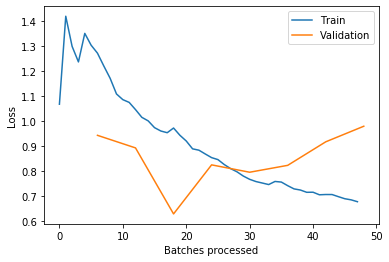

g18_224_lr_0.003_cyc_8_i1_ls


Better model found at epoch 0 with accuracy value: 0.7549999952316284.
Better model found at epoch 6 with accuracy value: 0.7599999904632568.
Better model found at epoch 7 with accuracy value: 0.7699999809265137.


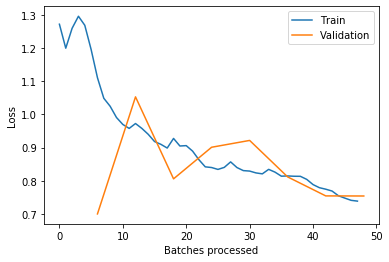

g18_224_lr_0.001_cyc_8_i1_ls


Better model found at epoch 0 with accuracy value: 0.6549999713897705.
Better model found at epoch 1 with accuracy value: 0.6850000023841858.


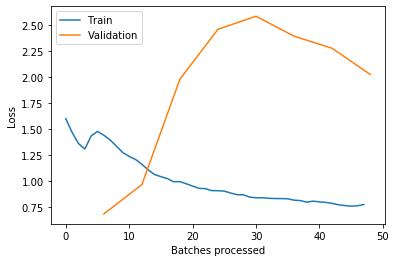

g18_224_lr_0.003_cyc_8_i2_ls


Better model found at epoch 0 with accuracy value: 0.7049999833106995.
Better model found at epoch 3 with accuracy value: 0.7149999737739563.
Better model found at epoch 4 with accuracy value: 0.7400000095367432.


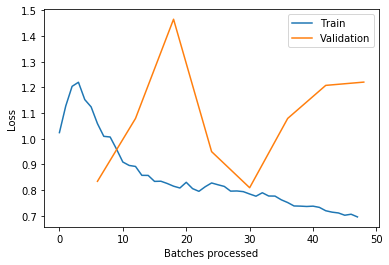

g18_224_lr_0.001_cyc_8_i2_ls


Better model found at epoch 0 with accuracy value: 0.6399999856948853.
Better model found at epoch 1 with accuracy value: 0.6949999928474426.


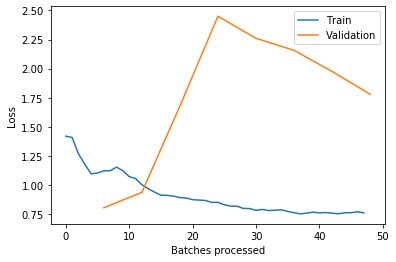

g18_224_lr_0.003_cyc_8_i3_ls


Better model found at epoch 0 with accuracy value: 0.6349999904632568.


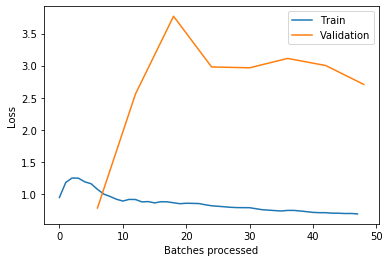

g18_224_lr_0.001_cyc_8_i3_ls


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.7149999737739563.


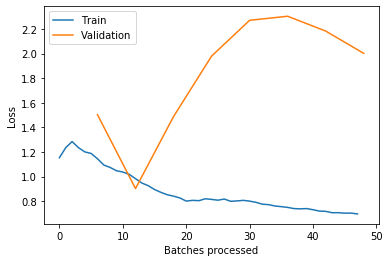

g18_224_lr_0.003_cyc_8_i4_ls


Better model found at epoch 0 with accuracy value: 0.8199999928474426.


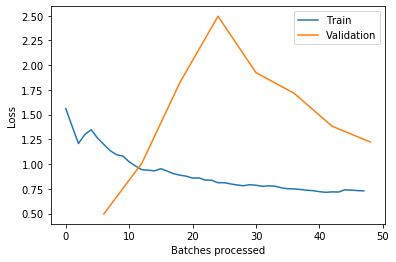

g18_224_lr_0.001_cyc_8_i4_ls


Better model found at epoch 0 with accuracy value: 0.6399999856948853.
Better model found at epoch 1 with accuracy value: 0.7400000095367432.


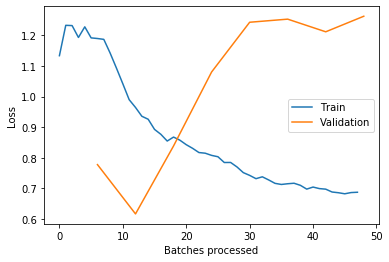

g18_224_lr_0.003_cyc_8_i5_ls


Better model found at epoch 0 with accuracy value: 0.7200000286102295.
Better model found at epoch 6 with accuracy value: 0.7300000190734863.


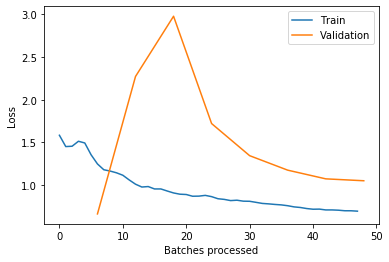

g18_224_lr_0.001_cyc_8_i5_ls


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.5049999952316284.
Better model found at epoch 2 with accuracy value: 0.5149999856948853.
Better model found at epoch 6 with accuracy value: 0.5199999809265137.
Better model found at epoch 7 with accuracy value: 0.5400000214576721.


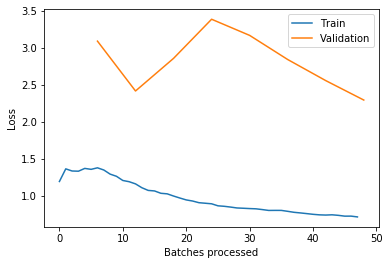

g18_224_lr_0.003_cyc_8_i6_ls


Better model found at epoch 0 with accuracy value: 0.7450000047683716.
Better model found at epoch 1 with accuracy value: 0.824999988079071.


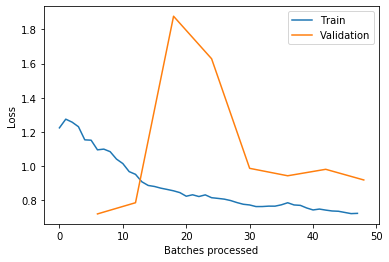

g18_224_lr_0.001_cyc_8_i6_ls


Better model found at epoch 0 with accuracy value: 0.5600000023841858.
Better model found at epoch 1 with accuracy value: 0.7699999809265137.


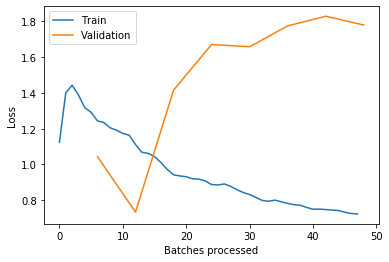

g18_224_lr_0.003_cyc_8_i7_ls


Better model found at epoch 0 with accuracy value: 0.7300000190734863.
Better model found at epoch 1 with accuracy value: 0.824999988079071.


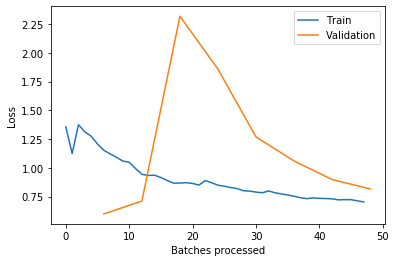

g18_224_lr_0.001_cyc_8_i7_ls


Better model found at epoch 0 with accuracy value: 0.5350000262260437.
Better model found at epoch 1 with accuracy value: 0.6349999904632568.
Better model found at epoch 2 with accuracy value: 0.6549999713897705.
Better model found at epoch 7 with accuracy value: 0.6700000166893005.


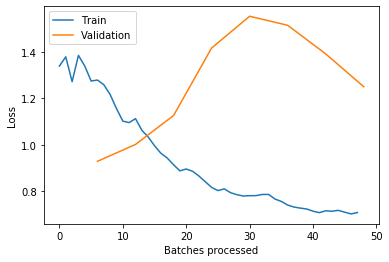

g18_224_lr_0.003_cyc_8_i8_ls


Better model found at epoch 0 with accuracy value: 0.6150000095367432.
Better model found at epoch 1 with accuracy value: 0.6850000023841858.
Better model found at epoch 2 with accuracy value: 0.7549999952316284.
Better model found at epoch 6 with accuracy value: 0.7749999761581421.


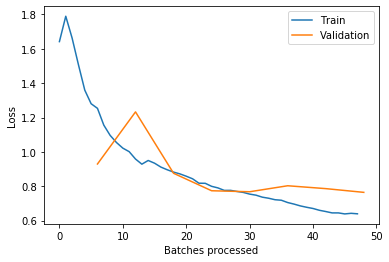

g18_224_lr_0.001_cyc_8_i8_ls


Better model found at epoch 0 with accuracy value: 0.5849999785423279.
Better model found at epoch 1 with accuracy value: 0.8349999785423279.


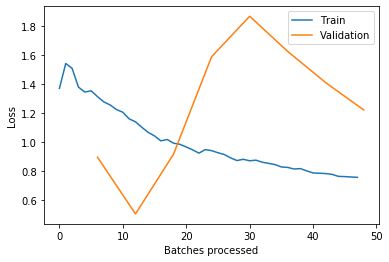

g18_224_lr_0.003_cyc_8_i9_ls


Better model found at epoch 0 with accuracy value: 0.7099999785423279.
Better model found at epoch 1 with accuracy value: 0.8349999785423279.


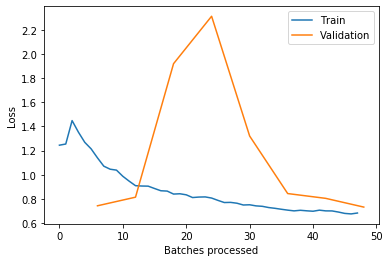

g18_224_lr_0.001_cyc_8_i9_ls


Better model found at epoch 0 with accuracy value: 0.7200000286102295.
Better model found at epoch 1 with accuracy value: 0.7900000214576721.


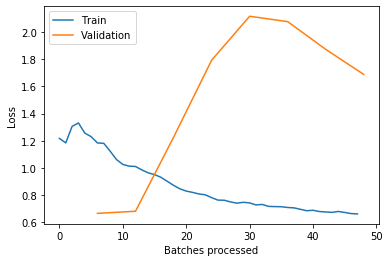

saved stats to: stats/g18_224_stats.p


In [51]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[3e-3,1e-3]):
        key = f'{key}_i{i}'
        do_train_ls(key, **params)
all_stats.save()

g18_224_lr_0.02_cyc_8_i0_ls


Better model found at epoch 0 with accuracy value: 0.7599999904632568.
Better model found at epoch 7 with accuracy value: 0.7699999809265137.


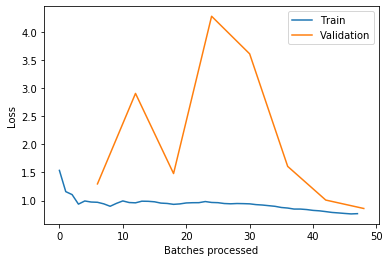

g18_224_lr_0.01_cyc_8_i0_ls


Better model found at epoch 0 with accuracy value: 0.7400000095367432.
Better model found at epoch 4 with accuracy value: 0.75.
Better model found at epoch 5 with accuracy value: 0.7699999809265137.


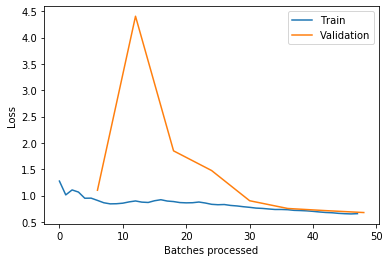

g18_224_lr_0.02_cyc_8_i1_ls


Better model found at epoch 0 with accuracy value: 0.5550000071525574.
Better model found at epoch 1 with accuracy value: 0.574999988079071.
Better model found at epoch 2 with accuracy value: 0.7950000166893005.
Better model found at epoch 4 with accuracy value: 0.8349999785423279.


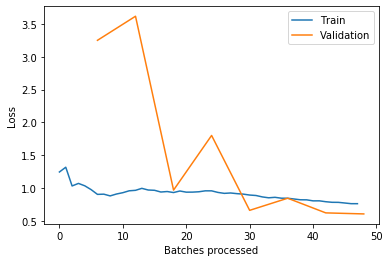

g18_224_lr_0.01_cyc_8_i1_ls


Better model found at epoch 0 with accuracy value: 0.7350000143051147.


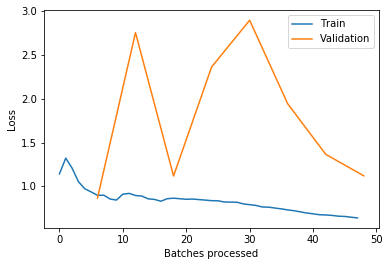

g18_224_lr_0.02_cyc_8_i2_ls


Better model found at epoch 0 with accuracy value: 0.7950000166893005.


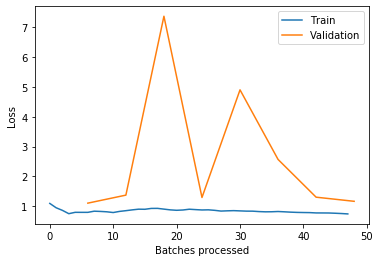

g18_224_lr_0.01_cyc_8_i2_ls


Better model found at epoch 0 with accuracy value: 0.6600000262260437.


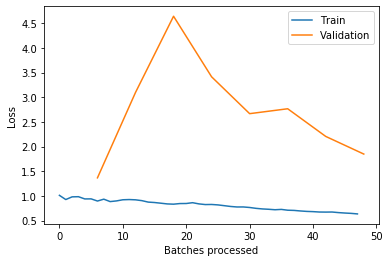

g18_224_lr_0.02_cyc_8_i3_ls


Better model found at epoch 0 with accuracy value: 0.6000000238418579.


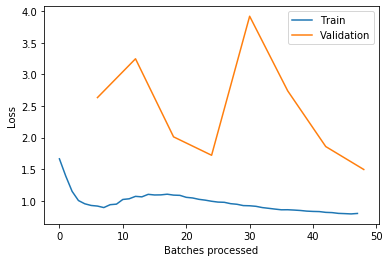

g18_224_lr_0.01_cyc_8_i3_ls


Better model found at epoch 0 with accuracy value: 0.6449999809265137.
Better model found at epoch 2 with accuracy value: 0.7950000166893005.


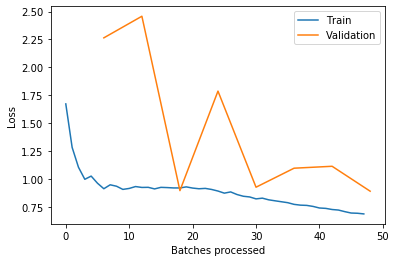

g18_224_lr_0.02_cyc_8_i4_ls


Better model found at epoch 0 with accuracy value: 0.6949999928474426.


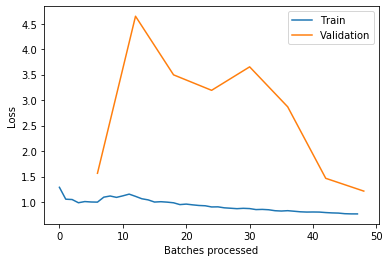

g18_224_lr_0.01_cyc_8_i4_ls


Better model found at epoch 0 with accuracy value: 0.7749999761581421.


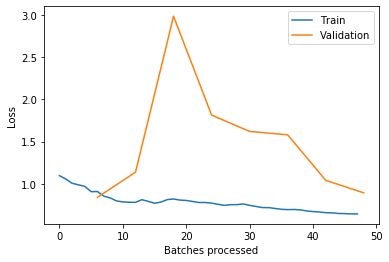

g18_224_lr_0.02_cyc_8_i5_ls


Better model found at epoch 0 with accuracy value: 0.6650000214576721.
Better model found at epoch 7 with accuracy value: 0.7350000143051147.


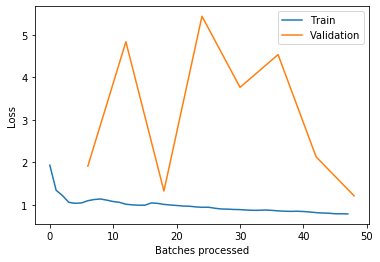

g18_224_lr_0.01_cyc_8_i5_ls


Better model found at epoch 0 with accuracy value: 0.7350000143051147.
Better model found at epoch 7 with accuracy value: 0.7400000095367432.


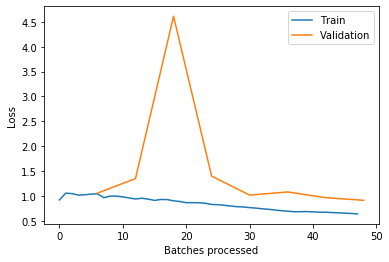

g18_224_lr_0.02_cyc_8_i6_ls


Better model found at epoch 0 with accuracy value: 0.8349999785423279.


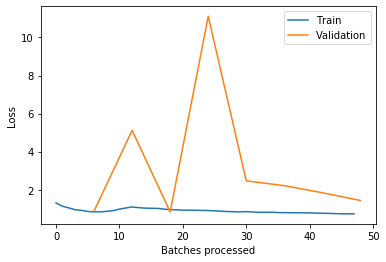

g18_224_lr_0.01_cyc_8_i6_ls


Better model found at epoch 0 with accuracy value: 0.800000011920929.
Better model found at epoch 4 with accuracy value: 0.8500000238418579.
Better model found at epoch 5 with accuracy value: 0.8600000143051147.


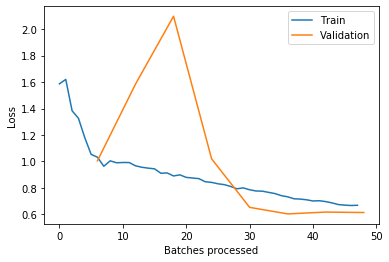

g18_224_lr_0.02_cyc_8_i7_ls


Better model found at epoch 0 with accuracy value: 0.7099999785423279.
Better model found at epoch 6 with accuracy value: 0.7350000143051147.
Better model found at epoch 7 with accuracy value: 0.7799999117851257.


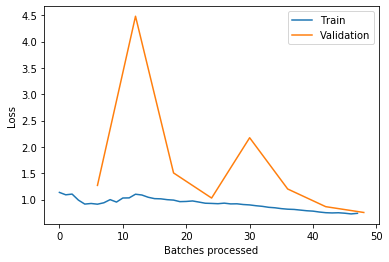

g18_224_lr_0.01_cyc_8_i7_ls


Better model found at epoch 0 with accuracy value: 0.7599999904632568.
Better model found at epoch 1 with accuracy value: 0.8149999976158142.
Better model found at epoch 5 with accuracy value: 0.8199999928474426.
Better model found at epoch 6 with accuracy value: 0.8500000238418579.
Better model found at epoch 7 with accuracy value: 0.8600000143051147.


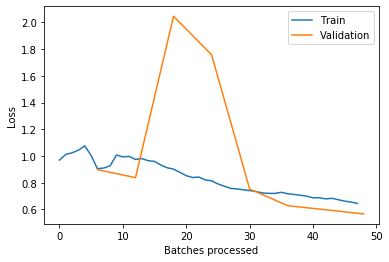

g18_224_lr_0.02_cyc_8_i8_ls


Better model found at epoch 0 with accuracy value: 0.8399999737739563.


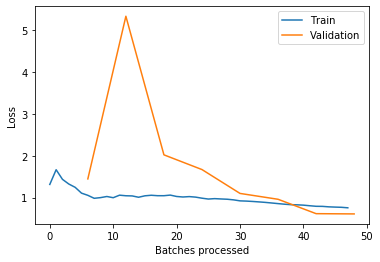

g18_224_lr_0.01_cyc_8_i8_ls


Better model found at epoch 0 with accuracy value: 0.7850000262260437.
Better model found at epoch 3 with accuracy value: 0.800000011920929.
Better model found at epoch 5 with accuracy value: 0.8450000286102295.
Better model found at epoch 6 with accuracy value: 0.8550000190734863.


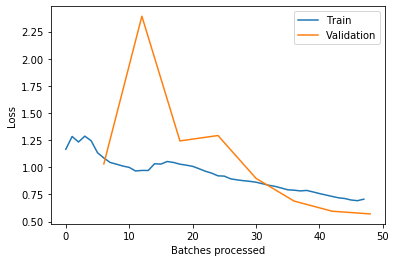

g18_224_lr_0.02_cyc_8_i9_ls


Better model found at epoch 0 with accuracy value: 0.5299999713897705.
Better model found at epoch 1 with accuracy value: 0.7049999833106995.
Better model found at epoch 3 with accuracy value: 0.7699999809265137.
Better model found at epoch 4 with accuracy value: 0.824999988079071.
Better model found at epoch 6 with accuracy value: 0.8349999785423279.
Better model found at epoch 7 with accuracy value: 0.8650000095367432.


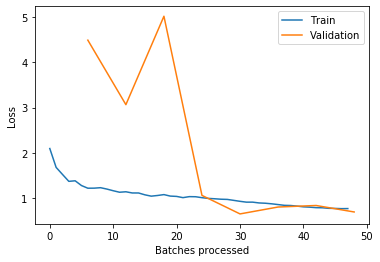

g18_224_lr_0.01_cyc_8_i9_ls


Better model found at epoch 0 with accuracy value: 0.800000011920929.
Better model found at epoch 6 with accuracy value: 0.8100000023841858.
Better model found at epoch 7 with accuracy value: 0.8550000190734863.


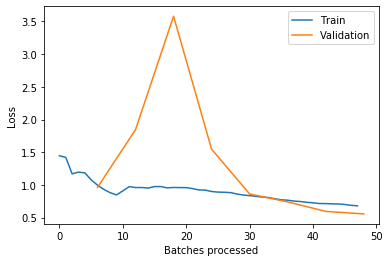

saved stats to: stats/g18_224_stats.p


In [52]:
for i in range(10):
    for key, params in get_params(all_cycles=[8], all_lr=[2e-2, 1e-2]):
        key = f'{key}_i{i}'
        do_train_ls(key, **params)
all_stats.save()

In [53]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.075  med: 0.195   Loss -- best: 0.250  med: 0.760

g18_224_lr_0.02_cyc_16_i0_m  error_rate: 0.075   accuracy: 0.925   loss:0.2497
g18_224_lr_0.01_cyc_12_i7  error_rate: 0.095   accuracy: 0.905   loss:0.2771
g18_224_lr_0.02_cyc_16_i8_m  error_rate: 0.095   accuracy: 0.905   loss:0.2541
g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.105   accuracy: 0.895   loss:0.3121
g18_224_lr_0.01_cyc_12_i6  error_rate: 0.110   accuracy: 0.890   loss:0.4106
g18_224_lr_0.02_cyc_16_i5_m  error_rate: 0.110   accuracy: 0.890   loss:0.3248
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.02_cyc_16_i7_m  error_rate: 0.115   accuracy: 0.885   loss:0.3384
g18_224_lr_0.02_cyc_16_i9_m  error_rate: 0.115   accuracy: 0.885   loss:0.3485


In [54]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.075  med: 0.195   Loss -- best: 0.250  med: 0.760

g18_224_lr_0.02_cyc_16_i0_m  error_rate: 0.075   accuracy: 0.925   loss:0.2497
g18_224_lr_0.01_cyc_12_i7  error_rate: 0.095   accuracy: 0.905   loss:0.2771
g18_224_lr_0.02_cyc_16_i8_m  error_rate: 0.095   accuracy: 0.905   loss:0.2541
g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.105   accuracy: 0.895   loss:0.3121
g18_224_lr_0.01_cyc_12_i6  error_rate: 0.110   accuracy: 0.890   loss:0.4106
g18_224_lr_0.02_cyc_16_i5_m  error_rate: 0.110   accuracy: 0.890   loss:0.3248
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.02_cyc_16_i7_m  error_rate: 0.115   accuracy: 0.885   loss:0.3384
g18_224_lr_0.02_cyc_16_i9_m  error_rate: 0.115   accuracy: 0.885   loss:0.3485


## Summary of Results

In [55]:
for key in [None, 'lr_0.03', 'lr_0.02', 'lr_0.01', 'lr_0.003', 'lr_0.001', 'lr_0.0003','lr_0.0001',
            'cyc_4', 'cyc_8', 'cyc_12',  'cyc_16', 
            '_m', 'ls', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_stats.get(), key=key, show_details=False)

Overall         Error -- best: 0.075  med: 0.195   Loss -- best: 0.250  med: 0.760
lr_0.03         Error -- best: 0.125  med: 0.205   Loss -- best: 0.450  med: 0.960
lr_0.02         Error -- best: 0.075  med: 0.190   Loss -- best: 0.250  med: 0.869
lr_0.01         Error -- best: 0.095  med: 0.178   Loss -- best: 0.277  med: 0.759
lr_0.003        Error -- best: 0.155  med: 0.195   Loss -- best: 0.496  med: 0.741
lr_0.001        Error -- best: 0.120  med: 0.228   Loss -- best: 0.484  med: 0.681
lr_0.0003       Error -- best: 0.115  med: 0.170   Loss -- best: 0.353  med: 0.493
lr_0.0001       Error -- best: 0.185  med: 0.268   Loss -- best: 0.403  med: 0.591
cyc_4           Error -- best: 0.160  med: 0.220   Loss -- best: 0.546  med: 0.958
cyc_8           Error -- best: 0.100  med: 0.190   Loss -- best: 0.347  med: 0.768
cyc_12          Error -- best: 0.095  med: 0.128   Loss -- best: 0.277  med: 0.480
cyc_16          Error -- best: 0.075  med: 0.125   Loss -- best: 0.250  med: 0.392
_m  

In [56]:
show_results(all_stats.get(), limit=10)

Overall         Error -- best: 0.075  med: 0.195   Loss -- best: 0.250  med: 0.760

g18_224_lr_0.02_cyc_16_i0_m  error_rate: 0.075   accuracy: 0.925   loss:0.2497
g18_224_lr_0.01_cyc_12_i7  error_rate: 0.095   accuracy: 0.905   loss:0.2771
g18_224_lr_0.02_cyc_16_i8_m  error_rate: 0.095   accuracy: 0.905   loss:0.2541
g18_224_lr_0.01_cyc_8_i9  error_rate: 0.100   accuracy: 0.900   loss:0.3468
g18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.105   accuracy: 0.895   loss:0.3121
g18_224_lr_0.01_cyc_12_i6  error_rate: 0.110   accuracy: 0.890   loss:0.4106
g18_224_lr_0.02_cyc_16_i5_m  error_rate: 0.110   accuracy: 0.890   loss:0.3248
g18_224_lr_0.01_cyc_8_i2  error_rate: 0.115   accuracy: 0.885   loss:0.5027
g18_224_lr_0.02_cyc_16_i7_m  error_rate: 0.115   accuracy: 0.885   loss:0.3384
g18_224_lr_0.02_cyc_16_i9_m  error_rate: 0.115   accuracy: 0.885   loss:0.3485


In [57]:
for key in ['lr_0.03', 'lr_0.02', 'lr_0.01', 'lr_0.003', 'lr_0.001', 'lr_0.0003','lr_0.0001',
            'cyc_4', 'cyc_8', 'cyc_12', 'cyc_16', 
            '_m', 'ls', 'lr_0.02_cyc_8', 'lr_0.01_cyc_8']:
    show_results(all_stats.get(), key=key, limit=6)
    print('\n')

lr_0.03         Error -- best: 0.125  med: 0.205   Loss -- best: 0.450  med: 0.960

g18_224_lr_0.03_cyc_8_i8  error_rate: 0.125   accuracy: 0.875   loss:0.5585
g18_224_lr_0.03_cyc_8_i0  error_rate: 0.140   accuracy: 0.860   loss:0.5730
g18_224_lr_0.03_cyc_8  error_rate: 0.145   accuracy: 0.855   loss:0.6643
g18_224_lr_0.03_cyc_8_i2  error_rate: 0.155   accuracy: 0.845   loss:1.0446
g18_224_lr_0.03_cyc_8_i4  error_rate: 0.155   accuracy: 0.845   loss:0.5489
g18_224_lr_0.03_cyc_8_i9  error_rate: 0.155   accuracy: 0.845   loss:0.7361


lr_0.02         Error -- best: 0.075  med: 0.190   Loss -- best: 0.250  med: 0.869

g18_224_lr_0.02_cyc_16_i0_m  error_rate: 0.075   accuracy: 0.925   loss:0.2497
g18_224_lr_0.02_cyc_16_i8_m  error_rate: 0.095   accuracy: 0.905   loss:0.2541
g18_224_lr_0.02_cyc_16_i1_m  error_rate: 0.105   accuracy: 0.895   loss:0.3121
g18_224_lr_0.02_cyc_16_i5_m  error_rate: 0.110   accuracy: 0.890   loss:0.3248
g18_224_lr_0.02_cyc_16_i7_m  error_rate: 0.115   accuracy: 0.

In [58]:
#assert False

## Inference

- try composite of 4 learners
- try test-time augmentation

In [59]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
name = top_results[0]
print(name)

g18_224_lr_0.02_cyc_16_i0_m



g18_224_lr_0.02_cyc_16_i0_m Validation tta=False
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          93%         91%        93%        0.92
PNEUMONIA       91%         93%        91%        0.92


Overall Accuracy: 92.00%


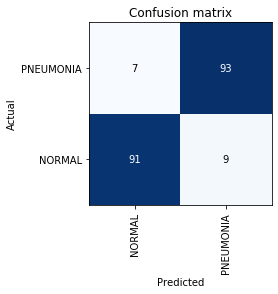

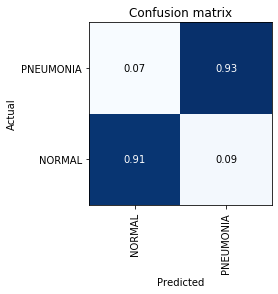

In [60]:
interp = get_interp(name)
print(f'\n{name} Validation tta=False')
analyze_interp(interp)


g18_224_lr_0.02_cyc_16_i0_m Test tta=False
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          90%         88%        90%        0.89
PNEUMONIA       88%         90%        88%        0.89


Overall Accuracy: 89.00%


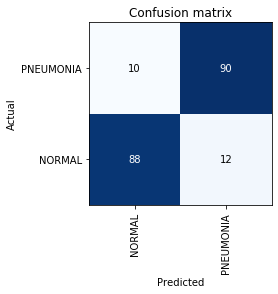

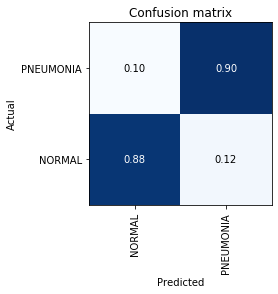

In [61]:
interp = get_interp_test(name)
print(f'\n{name} Test tta=False')
analyze_interp(interp)

#### Use TTA


g18_224_lr_0.02_cyc_16_i0_m Validation tta=True
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          96%         82%        97%        0.89
PNEUMONIA       84%         97%        82%        0.90


Overall Accuracy: 89.50%


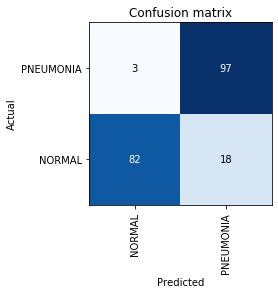

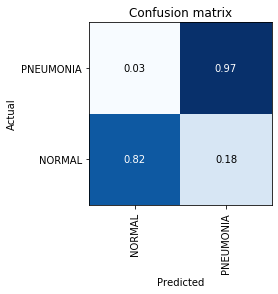

In [62]:
interp = get_interp(name, use_tta=True)
print(f'\n{name} Validation tta=True')
analyze_interp(interp)


g18_224_lr_0.02_cyc_16_i0_m Test tta=True
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          98%         81%        98%        0.89
PNEUMONIA       84%         98%        81%        0.90


Overall Accuracy: 89.50%


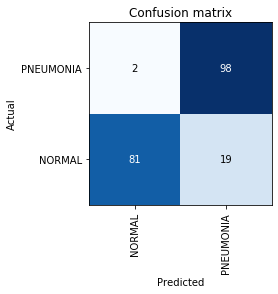

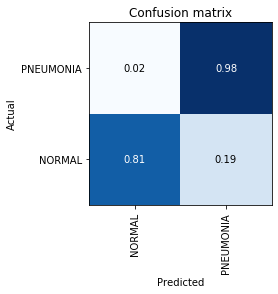

In [63]:
interp = get_interp_test(name, use_tta=True)
print(f'\n{name} Test tta=True')
analyze_interp(interp)

### Composite for Validation based on accuracy

In [64]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

_ = combine_predictions(top_interp)

accuracy -- mean: 0.925   median: 0.925   gmean: 0.925   hmean: 0.920


#### Show Individual - for Validation dataset

g18_224_lr_0.02_cyc_16_i0_m
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          93%         91%        93%        0.92
PNEUMONIA       91%         93%        91%        0.92


Overall Accuracy: 92.00%


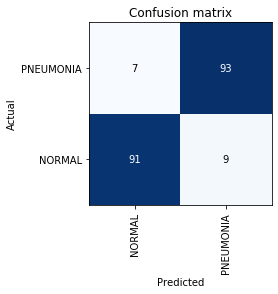

g18_224_lr_0.01_cyc_12_i7
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          93%         88%        93%        0.90
PNEUMONIA       89%         93%        88%        0.91


Overall Accuracy: 90.50%


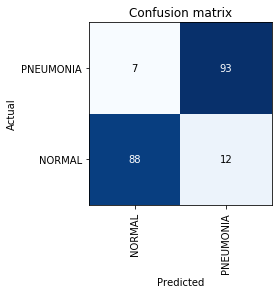

g18_224_lr_0.02_cyc_16_i8_m
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          91%         91%        91%        0.91
PNEUMONIA       91%         91%        91%        0.91


Overall Accuracy: 91.00%


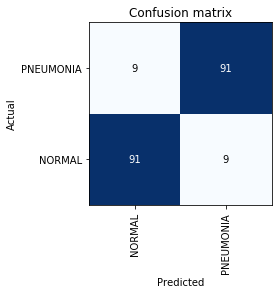

g18_224_lr_0.01_cyc_8_i9
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          93%         87%        93%        0.90
PNEUMONIA       88%         93%        87%        0.90


Overall Accuracy: 90.00%


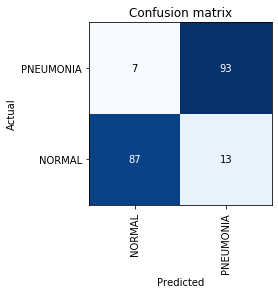

In [65]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

### Composite for Validation based on loss

In [66]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp(name)] for name in top_results]

_ = combine_predictions(top_interp)

accuracy -- mean: 0.930   median: 0.925   gmean: 0.925   hmean: 0.920


### Composite for Test based on accuracy

In [67]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.895   median: 0.895   gmean: 0.890   hmean: 0.880


#### Individual results for top 4

g18_224_lr_0.02_cyc_16_i0_m
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          90%         88%        90%        0.89
PNEUMONIA       88%         90%        88%        0.89


Overall Accuracy: 89.00%


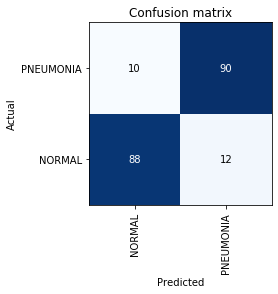

g18_224_lr_0.01_cyc_12_i7
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          92%         77%        93%        0.84
PNEUMONIA       80%         93%        77%        0.86


Overall Accuracy: 85.00%


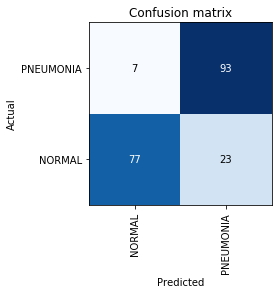

g18_224_lr_0.02_cyc_16_i8_m
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          89%         85%        90%        0.87
PNEUMONIA       86%         90%        85%        0.88


Overall Accuracy: 87.50%


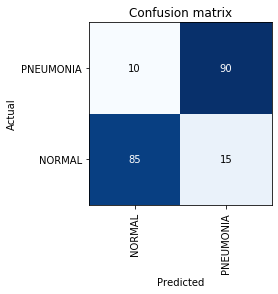

g18_224_lr_0.01_cyc_8_i9
            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          89%         76%        91%        0.82
PNEUMONIA       79%         91%        76%        0.85


Overall Accuracy: 83.50%


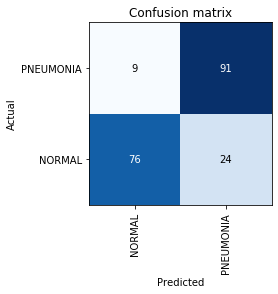

In [68]:
for name, interp in top_interp:
    print(name)
    analyze_interp(interp, include_norm=False)

#### Try again using TTA

In [69]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['error_rate'])[:4]]
top_interp = [[name, get_interp_test(name, use_tta=True)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.840   median: 0.850   gmean: 0.840   hmean: 0.840


### Composite for Test based on loss

In [70]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp_test(name)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.885   median: 0.875   gmean: 0.880   hmean: 0.885


#### Try again using TTA

In [71]:
top_results = [name for name, _ in sorted(all_stats.get(), key=lambda x:x[1]['loss'])[:4]]
top_interp = [[name, get_interp_test(name, use_tta=True)] for name in top_results]
_ = combine_predictions(top_interp)

accuracy -- mean: 0.840   median: 0.865   gmean: 0.835   hmean: 0.835


In [72]:
assert False

AssertionError: 

## Experiment with fine tuning classifier

In [ ]:
name = '18_448cut_lr_0.02_cyc_16_i6_m'

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [ ]:
learn.fit_one_cycle(1, max_lr=slice(2e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-4))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5))

In [ ]:
learn = get_learner()
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-5))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(2e-4))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn = get_learner(ps=0.8)
learn.load(name)
learn.unfreeze()
learn.fit_one_cycle(16, max_lr=slice(1e-6, 1e-6))

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=2)
stats, new_name

In [ ]:
learn, stats, new_name = refine_learner(name, cycles=8)
stats, new_name

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=8)
    foo.append([1, stats])
foo

In [ ]:
foo = []
for i in range(10):
    learn, stats, new_name = refine_learner(name, cycles=16)
    foo.append([1, stats])
    print('\n')
foo